# Fiber Learning Model Demo

In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import yaml
import lightning_trainable
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
from pathlib import Path
matplotlib.rcParams.update({'font.size': 16})
import gc         # garbage collect library
import shutil
from scipy.special import kl_div
import h5py

In [2]:
save = True
plot_dir = "col_mnist_plots"
if save:
    Path(f"plots/{plot_dir}").mkdir(parents=True, exist_ok=True)

In [3]:
def plot_images_28(data, title, model, n_rows=2, n_columns=9, save=False, model_name=None):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(2*n_columns, 2*n_rows))
    for i in range(n_rows):
        for j in range(n_columns):
            axes[i][j].imshow(data[i*n_columns + j].cpu().reshape(-1, 28, 28).T, vmin=0, vmax=1)
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle(title)
    if save:
        Path(f"plots/{plot_dir}/{model_name}").mkdir(parents=True, exist_ok=True)
        plt.savefig(f"plots/{plot_dir}/{model_name}/{title}.png", bbox_inches='tight')
        plt.close()

In [177]:
from PIL import Image

def stack_images_vertically(image_paths, output_path):
    images = [Image.open(path) for path in image_paths]
    
    # Calculate the total height and maximum width
    total_height = sum(image.height for image in images)
    max_width = max(image.width for image in images)
    
    # Create a new blank image with the appropriate dimensions
    stacked_image = Image.new('RGBA', (max_width, total_height))
    
    # Paste each image into the new image
    y_offset = 0
    for image in images:
        stacked_image.paste(image, (0, y_offset))
        y_offset += image.height
    
    # Save the result
    stacked_image.save(output_path)

In [161]:
checkpoint = lightning_trainable.utils.find_checkpoint(root="lightning_logs/density", version=0, epoch=149)
like_model = fff.fiber_model.FiberModel.load_from_checkpoint(checkpoint).eval()

(240000, 3, 28, 28)
Loading lossless_ae checkpoint from:  lightning_logs/Lossless_VAE/checkpoints/last.ckpt
cond_dim:  0
output_dim:  108
54


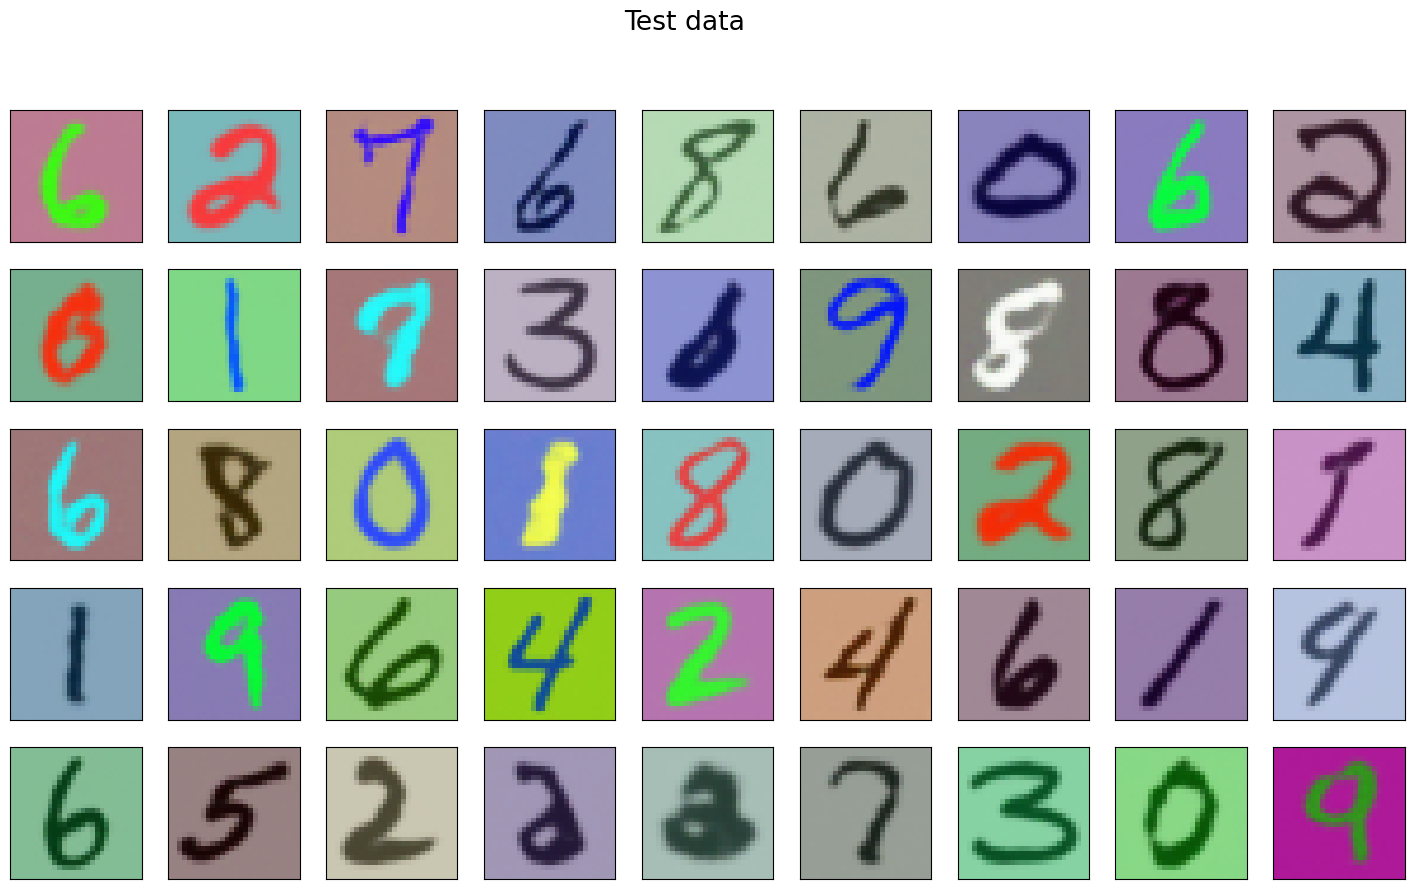

In [168]:
x_sampled = model.sample((10000,))
like_samples = x_sampled
plot_images_28(x_sampled,"Test data","",n_rows=5)

In [163]:
z_list = []
device = model.device
torch.set_grad_enabled(False)
test_set = torch.utils.data.TensorDataset(Xt)
dataloader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False)
for i, batch in enumerate(dataloader):
    test_conditioned = model.apply_conditions(batch)
    test_c = test_conditioned.condition
    test_samples = test_conditioned.x0.to(device).reshape(-1,3*28*28)
    z_list.append(model.encode(test_samples, torch.empty([test_samples.shape[0],0], device=device)).cpu())
z_list = torch.cat(z_list, 0)

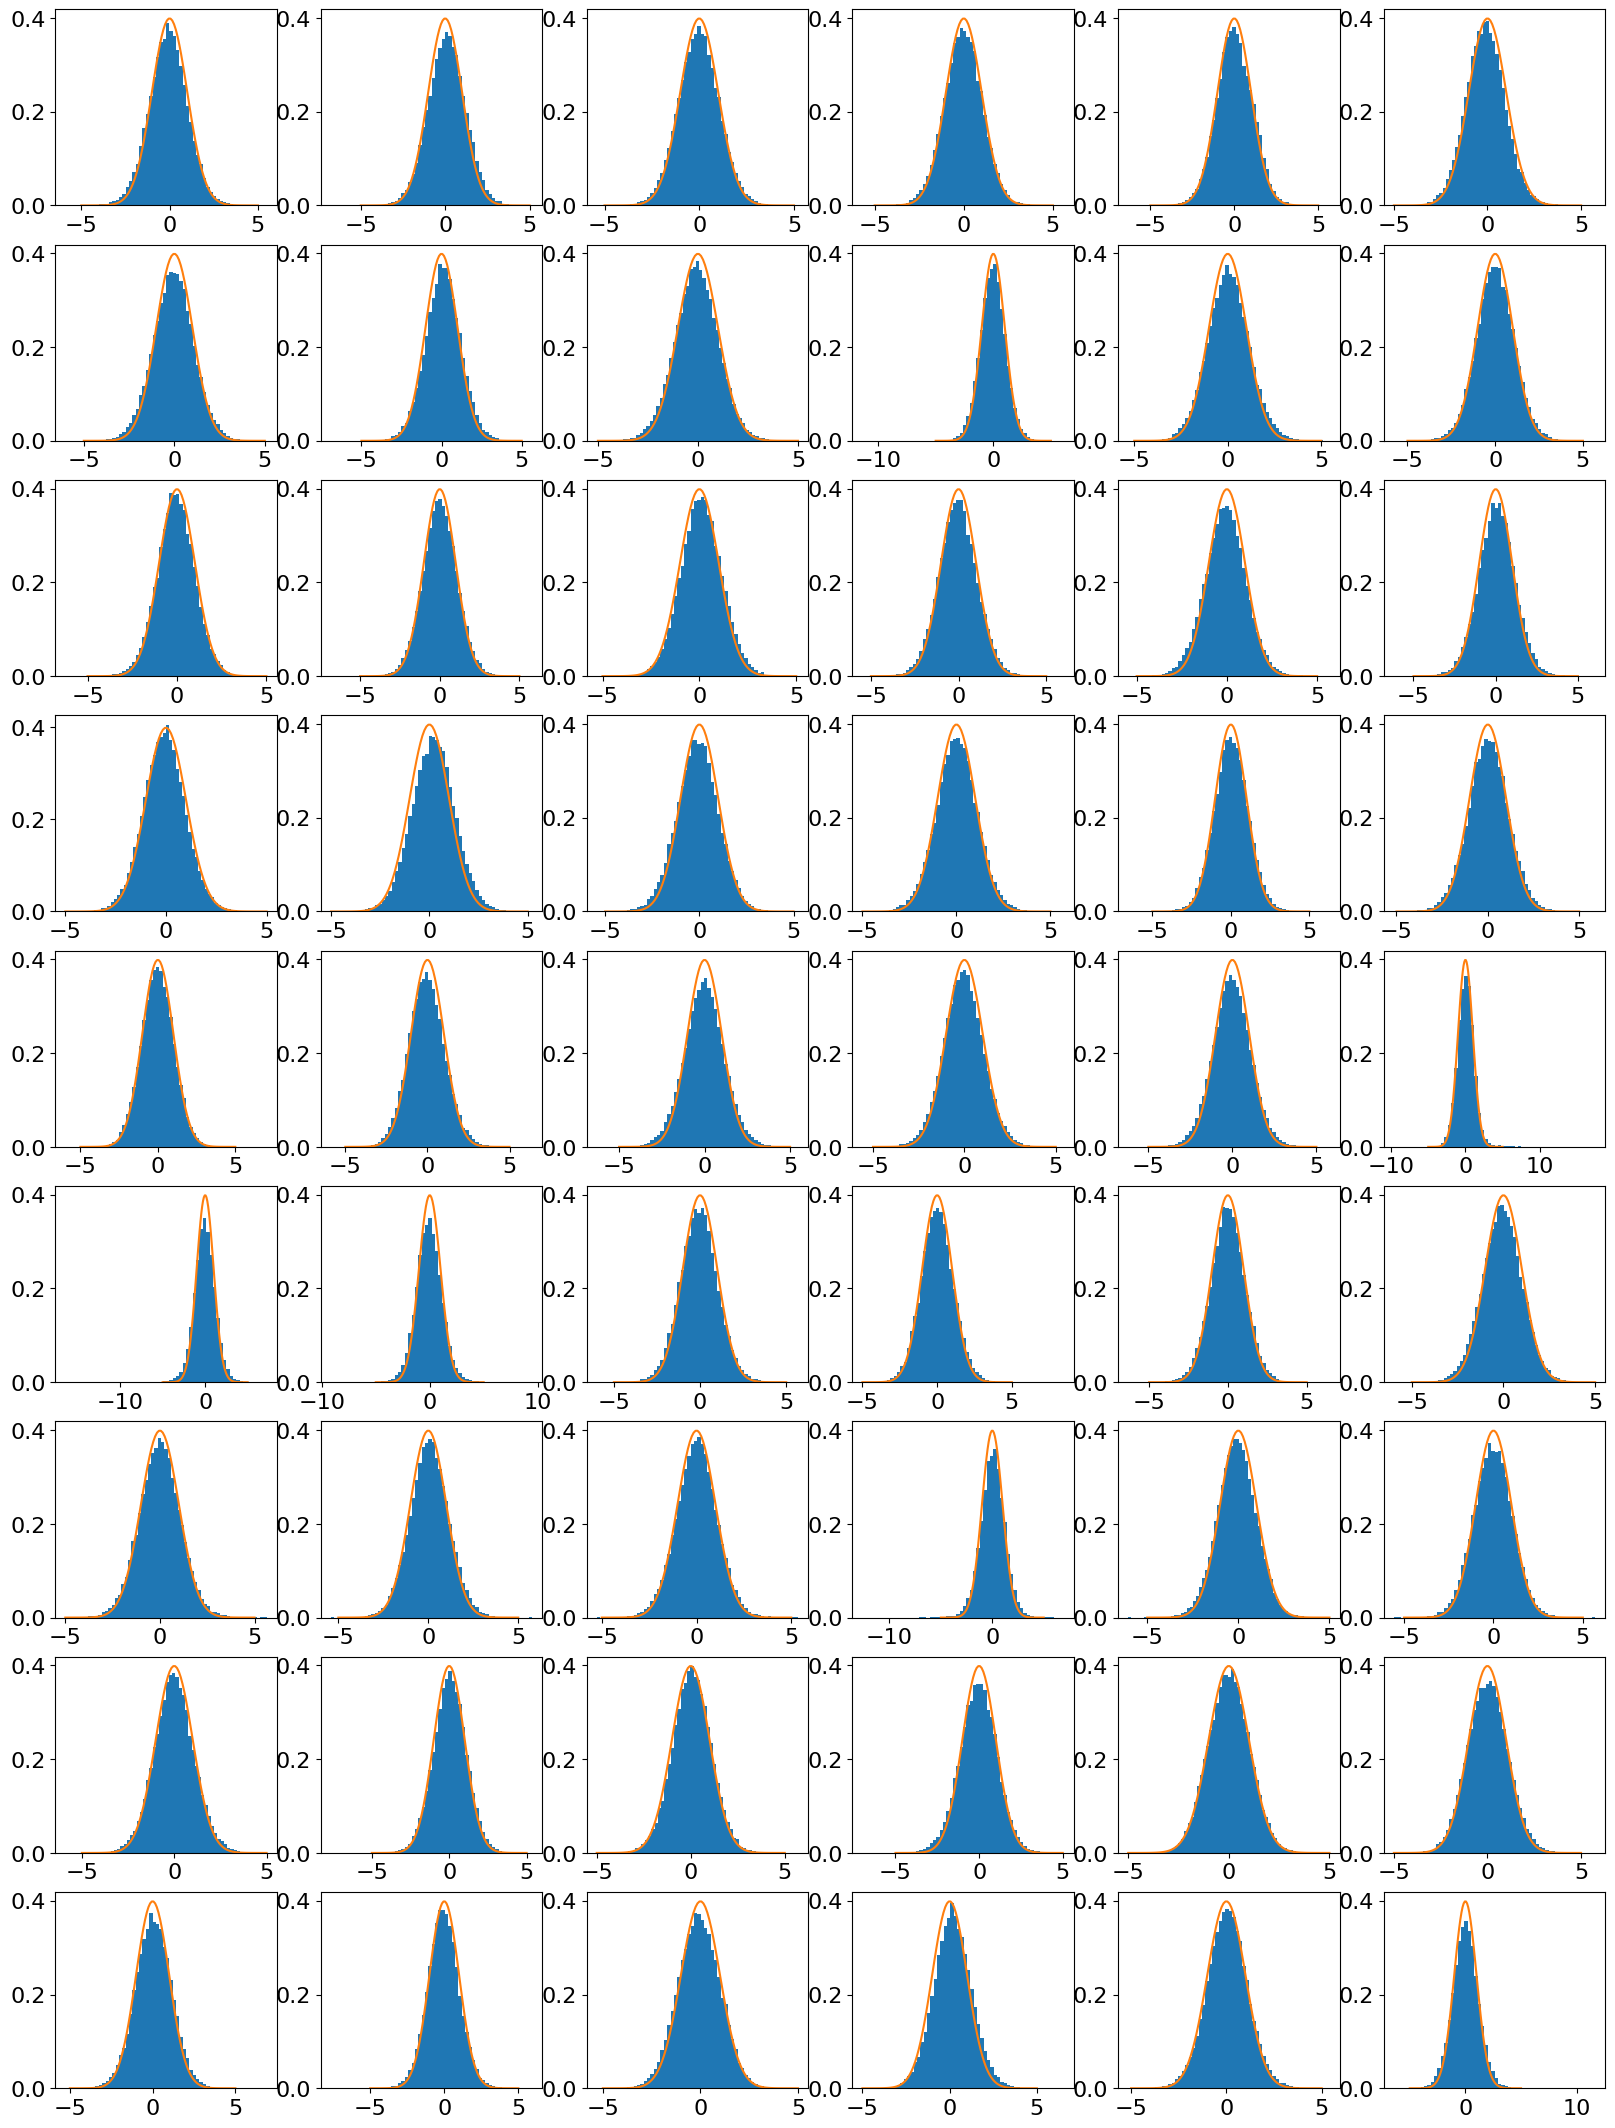

In [164]:
a = np.linspace(-5,5,100)
nrows = 54//6
fig, axes = plt.subplots(nrows=nrows, ncols=6, figsize=(20, nrows*3))
for i in range(nrows):
    for j in range(6):
        axes[i][j].hist(z_list[:,i*6+j], bins=60, label="Samples", density=True)
        axes[i][j].plot(a, normal(a, 0, 1))
#fig.suptitle("Laten

## Evaluate fiber-learning model

In [4]:
def normal(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma
def gaussian_mix_dense(x):
    return 0.6 * normal(x, 0.7, 0.08) + 0.35 * normal(x, 0.5, 0.015) + 0.05 * normal(x, 0.1, 0.02)

In [5]:
def compute_Wasserstein(d1,d2):
    d1 = d1.sort().values.cpu()
    d2 = d2.sort().values.cpu()
    distance = (d1-d2)
    return distance.abs().mean()

In [6]:
#If you want to load a trained model
plot_dir = "col_mnist_plots"
checkpoint = lightning_trainable.utils.find_checkpoint(root="lightning_logs/100_f3f", version=0, epoch="last")
model = fff.fiber_model.FiberModel.load_from_checkpoint(checkpoint).eval()

(240000, 3, 28, 28)
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96


/export/home/wjoran/FFF/fff/fiber_model.py:141: UserWarning: Overwriting model_spec from config with loaded model!
  warn("Overwriting model_spec from config with loaded model!")


Loading lossless_ae checkpoint from:  lightning_logs/Lossless_VAE/checkpoints/last.ckpt
cond_dim:  0
output_dim:  108
cond_dim:  48
output_dim:  3


In [175]:
subject_model = model.subject_model.model

In [176]:
torch.set_grad_enabled(False)

In [6]:
def Decolorize(x_colored):
    def detect_colors(x_data):
        background_colors = torch.mean(x_data[:,:,:,0],-1)
        return background_colors
    x_c = x_colored.reshape(-1,3,28,28)
    c = detect_colors(x_c)
    # x_c = (1-x) c + x * ((c+0.5)%1)
    #--> x = (x_c-c)/((c+0.5)%1 - c)
    c_image = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
    x_dc = (x_c-c_image) / ((c_image+0.5)%1 - c_image)
    #return torch.abs(x_dc)[:,2,:,:]
    #return torch.mean(x_dc.abs(),1)
    return x_dc.abs(), c

In [7]:
with h5py.File('/export/data/wjoran/FFF/data/cc_mnist/data.h5', 'r') as f:
    #Xtr = torch.from_numpy(f['train_images'][:])
    #ztr = torch.from_numpy(f['train_z'][:])
    #jtr = torch.from_numpy(f['train_jac'][:])
    Xt = torch.from_numpy(f['test_images'][:])
    #ct = torch.from_numpy(f['test_z'][:])
    #jt = torch.from_numpy(f['test_jac'][:])

In [8]:
test_set = torch.utils.data.TensorDataset(Xt)

In [9]:
@torch.no_grad()
def evaluate_model(model2plt, N_samples_per_c=1, save=False, save_name=None, batch_size=2048):
    N=None
    n_rows=2
    device = model2plt.device
    fiber_samples = []
    fiber_loss = []
    data_samples = []
    reconstructions = []
    
    #dataloader = torch.utils.data.DataLoader(model2plt.test_data, batch_size=batch_size, shuffle=False)
    dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    print("sampling...")
    
    for sam_i in range(N_samples_per_c):
        fiber_samples_sami = []
        fiber_loss_sami = []
        data_samples_sami = []
        reconstructions_sami = []
        for i, batch in enumerate(dataloader):
            #with h5py.File('notebooks/Fiber_Learning/sanders_results_10.h5', 'r') as f:
            #    z_samples = torch.from_numpy(f['test_z_samples'][:])
            batch = batch[:1]
            batch[0] = batch[0].to(device)
            batch.append(model2plt.subject_model.encode(batch[0], torch.empty(batch[0].shape[0], device=device)))
            test_conditioned = model2plt.apply_conditions(batch)
            test_c = test_conditioned.condition
            test_samples = test_conditioned.x0.to(device)
            test_c0 = torch.empty((test_samples.shape[0], 0), device=test_samples.device, dtype=test_samples.dtype)
        
            #enc = model2plt.encode_lossless(test_samples[:N],test_c[:N].to(device), mu_var=False)
            #x_sampled = model2plt.decode_lossless(enc[:N],test_c[:N].to(device))
            #x_sampled = model2plt.decode_lossless(z_samples.to(device),test_c[:N].to(device))
            #plot_images_28((x_sampled.reshape(-1,3,28,28)-test_samples[:N].reshape(-1,3,28,28)).abs(),"Residuals","",n_rows=n_rows)
            #x_sampled = model2plt.sample((test_samples[:N].shape[0],),test_c[0].unsqueeze(0).repeat(N,1).to(device))
            x_sampled = model2plt.sample((test_samples[:N].shape[0],),test_c[:N].to(device))
            #x_sampled = test_samples[:N]
            
            x_dc = torch.mean(Decolorize(x_sampled)[0],1)
            c_sm = torch.empty((test_c.shape[0], 0), device=test_c.device)[:N]
            conditioned = subject_model.apply_conditions((x_dc,))
            c_sm = conditioned.condition
            x_sm = conditioned.x0
            xc = subject_model.encode(x_sm.to(subject_model.device), c_sm.to(subject_model.device))
            fiber_loss_sami.append(torch.sqrt(torch.sum((xc-test_c)**2,-1)/float(xc.shape[-1])))
            #print(torch.abs(xc.cpu()-test_c).mean(-1))
            #print(torch.abs(test_c[1:]-test_c[:-1]).mean(-1))
            reconstructions_sami.append(subject_model.decode(test_c[:N].to(subject_model.device), c_sm.to(subject_model.device)).cpu())
            reconstructions1 = subject_model.decode(xc.to(subject_model.device), c_sm.to(subject_model.device)).cpu()
            fiber_samples_sami.append(x_sampled.cpu())
            data_samples_sami.append(test_samples.cpu())
            #xc = xc.detach().cpu()
            if i==0 and sam_i==0:
                plot_images_28(data_samples_sami[-1],"Test data","",n_rows=n_rows, save=save, model_name=save_name)
                plot_images_28(fiber_samples_sami[-1],"Samples","",n_rows=n_rows, save=save, model_name=save_name)
                plot_images_28(x_dc,"Samples decolored","",n_rows=n_rows, save=save, model_name=save_name)
                plot_images_28(reconstructions_sami[-1],"Reconstructed conditions","",n_rows=n_rows, save=save, model_name=save_name)
                plot_images_28(reconstructions1,"Reconstructed decolored samples","",n_rows=n_rows, save=save, model_name=save_name)
                plot_images_28((reconstructions_sami[-1].reshape(-1,28,28)-x_dc.cpu().reshape(-1,28,28)).abs(),"Residuals","",n_rows=n_rows, save=save, model_name=save_name)
                    
        fiber_samples.append(torch.cat(fiber_samples_sami,0))
        data_samples.append(torch.cat(data_samples_sami,0))
        reconstructions.append(torch.cat(reconstructions_sami,0))
        fiber_loss.append(torch.cat(fiber_loss_sami,0).cpu())

    if save:
        with h5py.File(f'plots/{plot_dir}/{save_name}/fiber_loss.h5', 'w') as f:
            f.create_dataset('fiber_loss', data=fiber_loss)
    #print(data_samples[0].shape)
    fl_means = []
    for fl in fiber_loss:
        fl_means.append(fl.mean().numpy())
    fl_mean = np.array(fl_means).mean()
    std_fl_mean = np.array(fl_means).std()/np.sqrt(float(len(fl_means)))
    #print("fiber_loss mean is: ", fl_mean, " +- ", std_fl_mean)
    """
    latent_dim = xc[0].shape[0]
    residual = torch.sum((xc-test_c[:])**2, dim=1)/latent_dim
    print(x_sampled[residual<2].shape[0])
    plot_images_28(x_sampled[residual<2],"","")
    plot_images_28(x_dc[residual<2],"","")
    delta_coarse = torch.sqrt(residual)

    medians.append(torch.median(delta_coarse).numpy().item())
    means.append(torch.mean(delta_coarse).numpy().item())
    #print("median fiber deviation on test set: ", torch.median(delta_coarse))
    #print("mean fiber deviation on test set: ", torch.mean(delta_coarse))
    """
    return (fl_mean, std_fl_mean), fiber_samples, data_samples, reconstructions

In [194]:
fiber_loss, samples_list, test_samples_list, rec_list = evaluate_model(model, 2, save=False, save_name="f3f")

sampling...


In [10]:
def compute_kl_and_deviation(sample_list,n_bins=100):
    kls_r = []
    kls_g = []
    kls_b = []
    dev = []
    for samples in sample_list:
        x_dc, colors = Decolorize(samples)
        # deviation:
        max_pix = torch.max(x_dc.mean(1).reshape(-1,28*28),-1)[0].cpu()
        dev.append(torch.abs(max_pix - 1).mean().numpy())
        # kls:
        kls_c = []
        for c in range(3):
            H, bins = np.histogram(colors[:,c].cpu(), bins=n_bins, range=[0, 1],density=True)
            kls_c.append(np.sum(kl_div(H, gaussian_mix_dense(bins[:-1]+(bins[1]-bins[0])/2))))
        kls_r.append(kls_c[0])
        kls_g.append(kls_c[1])
        kls_b.append(kls_c[2])
    kls_dev = [kls_r, kls_g, kls_b, dev]
    kls_dev_mean = []
    kls_dev_std = []
    for obj in kls_dev:
        mean = np.array(obj).mean()
        std = np.array(obj).std()/np.sqrt(float(len(sample_list)))
        magnitude = int(np.floor(np.log10(abs(std))))
        # Calculate how many decimal places to round to
        if magnitude <= 0:
            decimals = abs(magnitude) + 1
        else:
            decimals = 0
        # Round the values
        rounded_mean = np.round(mean, decimals)
        rounded_std = np.round(std, decimals)
        kls_dev_mean.append(rounded_mean)
        kls_dev_std.append(rounded_std)
    return kls_dev_mean, kls_dev_std

In [11]:
def plot_evaluation(samples_list, test_samples_list, rec_list, save=False, save_name=None):
    print("plotting...")
    samples = samples_list[0]
    test_samples = test_samples_list[0]
    rec = rec_list[0]
    kl_div_all, kl_div_all_std = compute_kl_and_deviation(samples_list)

    mean_kl = np.round(np.array(kl_div_all[:3]).mean(),4)
    mean_kl_std = np.round(np.array(kl_div_all[:3]).std(),4)
    
    x_dc, c = Decolorize(samples)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
    plt.suptitle(r"$mean KL=%s\pm %s$" % (mean_kl,mean_kl_std))
    axes[0,0].set_title(r"max pixel value$\hat{\,\,\,=}$ digit color accuracy")
    max_bin = 1.5
    #axes[0,0].hist(torch.max(torch.mean(x_dc,1).reshape(-1,28*28),-1)[0].cpu(),bins=60, alpha=0.5, label="mean")
    bins = np.linspace(0, max_bin, 60)
    regular_bins = bins[:-1]  # Bins from -3 to 3
    # Calculate how many data points are above 1.5 (overflow bin)
    hist1 = torch.max(x_dc[:,0,:,:].reshape(-1,28*28),-1)[0].cpu()
    num_overflow = len(hist1[hist1 > max_bin])
    hist2 = torch.max(x_dc[:,1,:,:].reshape(-1,28*28),-1)[0].cpu()
    num_overflow += len(hist2[hist2 > max_bin])
    hist3 = torch.max(x_dc[:,2,:,:].reshape(-1,28*28),-1)[0].cpu()
    num_overflow += len(hist3[hist3 > max_bin])
    hist4 = torch.max(x_dc.mean(1).reshape(-1,28*28),-1)[0].cpu()
    num_overflow += len(hist4[hist4 > max_bin])
    
    last_bin_edge = regular_bins[-1]  # The end of the last regular bin (which is at 3)
    overflow_position = [last_bin_edge + (bins[1] - bins[0]) / 2]  # Position for the overflow bar

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    textstr = r'$deviation=%s$' % (kl_div_all[3], ) + r" $\pm\,%s$" % (kl_div_all_std[3],)
    axes[0,0].text(0.05, 0.95, textstr, transform=axes[0,0].transAxes, fontsize=13,
            verticalalignment='top', bbox=props)
    axes[0,0].hist(hist1, bins=regular_bins, label="r", color="r",alpha=0.2, linewidth=0.7,histtype='stepfilled')
    axes[0,0].bar(overflow_position, num_overflow, width=bins[1] - bins[0], color='red', label=f'overflow (>{max_bin})')
    axes[0,0].hist(hist2, bins=regular_bins, label="g", color="g",alpha=0.2, linewidth=0.7,histtype='stepfilled')
    axes[0,0].hist(hist3, bins=regular_bins, label="b", color="b",alpha=0.2, linewidth=0.7,histtype='stepfilled')
    axes[0,0].hist(hist4, bins=regular_bins, label="mean", color="black",histtype='step', linewidth=1.2)
    axes[0,0].plot((1,1),(0,300),c="r", linewidth=3, label="truth")
    axes[0,0].grid(True)
    axes[0,0].legend(prop={'size': 13}, loc=(0.05,0.35))
    axes[0,0].set_yscale("log")

    textstr = r'$KL=%s$' % (kl_div_all[0], ) + r" $\pm\,%s$" % (kl_div_all_std[0],)    
    # place a text box in upper left in axes coords
    axes[0,1].text(0.05, 0.95, textstr, transform=axes[0,1].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    axes[0,1].set_title(r"background r-channel distribution")
    H, bins = np.histogram(c[:,0].cpu(), bins=100, range=[0, 1],density=True)
    axes[0,1].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
    x = np.linspace(0,1,1000)
    axes[0,1].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
    axes[0,1].legend()
    
    axes[1,0].set_title(r"background g-channel distribution")
    textstr = r'$KL=%s$' % (kl_div_all[1], ) + r" $\pm\,%s$" % (kl_div_all_std[1],)
    axes[1,0].text(0.05, 0.95, textstr, transform=axes[1,0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    H, bins = np.histogram(c[:,1].cpu(), bins=100, range=[0, 1],density=True)
    axes[1,0].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
    axes[1,0].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
    axes[1,0].legend()
    
    axes[1,1].set_title(r"background b-channel distribution")
    textstr = r'$KL=%s$' % (kl_div_all[2], ) + r" $\pm\,%s$" % (kl_div_all_std[2],)
    axes[1,1].text(0.05, 0.95, textstr, transform=axes[1,1].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    H, bins = np.histogram(c[:,2].cpu(), bins=100, range=[0, 1],density=True)
    axes[1,1].bar(bins[:-1]+(bins[1]-bins[0])/2,H,width=bins[1]-bins[0], label="samples")
    axes[1,1].plot(x, gaussian_mix_dense(x), linewidth=2, label="truth", color="tab:orange")
    axes[1,1].legend()
    if save:
        title = "color_matching"
        Path(f"plots/{plot_dir}/{save_name}").mkdir(parents=True, exist_ok=True)
        plt.savefig(f"plots/{plot_dir}/{save_name}/{title}.png", bbox_inches='tight')
        plt.close()
    plot_images_28(torch.abs(torch.mean(x_dc,1)-rec.reshape(-1,28,28)),"mean decolored","",n_rows=2, save=save, model_name=save_name)
    plot_images_28(torch.abs(x_dc[:,0,:,:]-rec.reshape(-1,28,28)),"r-channel decolored","",n_rows=2, save=save, model_name=save_name)
    plot_images_28(torch.abs(x_dc[:,1,:,:]-rec.reshape(-1,28,28)),"g-channel decolored","",n_rows=2, save=save, model_name=save_name)
    plot_images_28(torch.abs(x_dc[:,2,:,:]-rec.reshape(-1,28,28)),"b-channel decolored","",n_rows=2, save=save, model_name=save_name)
    return (mean_kl, mean_kl_std), kl_div_all, kl_div_all_std

In [223]:
mean_kl_std, kl_means, kl_stds = plot_evaluation(samples_list, test_samples_list, rec_list,save=False, save_name="f3f")

plotting...


In [28]:
names = ["250_f3f", "250_f3f_0", "250_f3f_1", "250_f3f_2", "250_fff", "250_fff_0", "250_fff_1", "250_fff_2", "100_nf", "100_nf_0", "100_nf_1", "100_dnf", "100_dnf_0", "100_dnf_1", "100_mlf", "250_mlf_0", "250_mlf_1", "1000_diff", "100_nf_2", "100_dnf_2", "250_cfm"]
#names = ["100_nf_2", "100_dnf_2", "250_cfm"]
#fiber_losses_all = []
#mean_kl_std_all = []

100_nf_2
(240000, 3, 28, 28)
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96
Loading lossless_ae checkpoint from:  lightning_logs/Lossless_VAE/checkpoints/last.ckpt
cond_dim:  0
output_dim:  108
54
sampling...
plotting...
19
100_dnf_2
(240000, 3, 28, 28)
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96
Loading lossless_ae checkpoint from:  lightning_logs/Lossless_VAE/checkpoints/last.ckpt
cond_dim:  0
output_dim:  108
sampling...
plotting...


/tmp/ipykernel_33422/1317845250.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(2*n_columns, 2*n_rows))


20
250_cfm
(240000, 3, 28, 28)
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96
Loading lossless_ae checkpoint from:  lightning_logs/Lossless_VAE/checkpoints/last.ckpt
cond_dim:  0
output_dim:  108
Using a linear interpolation
sampling...
plotting...
21


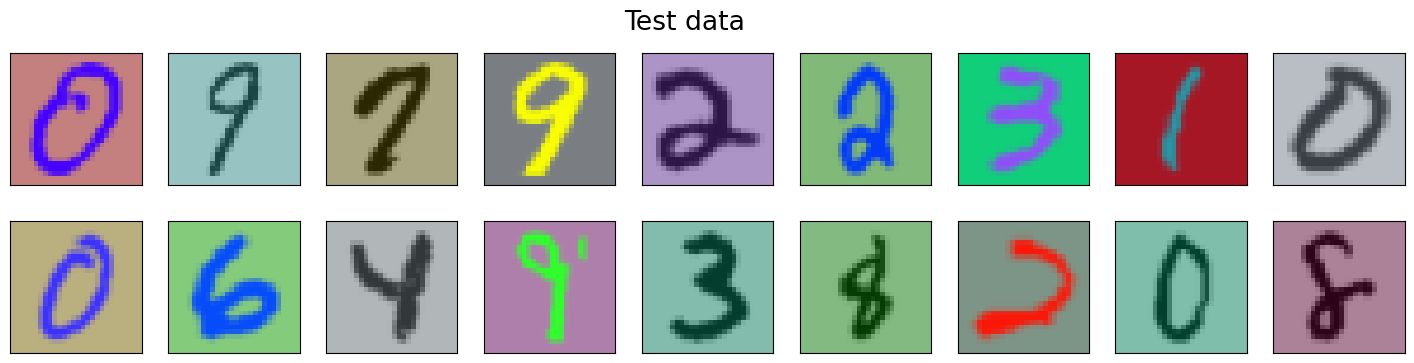

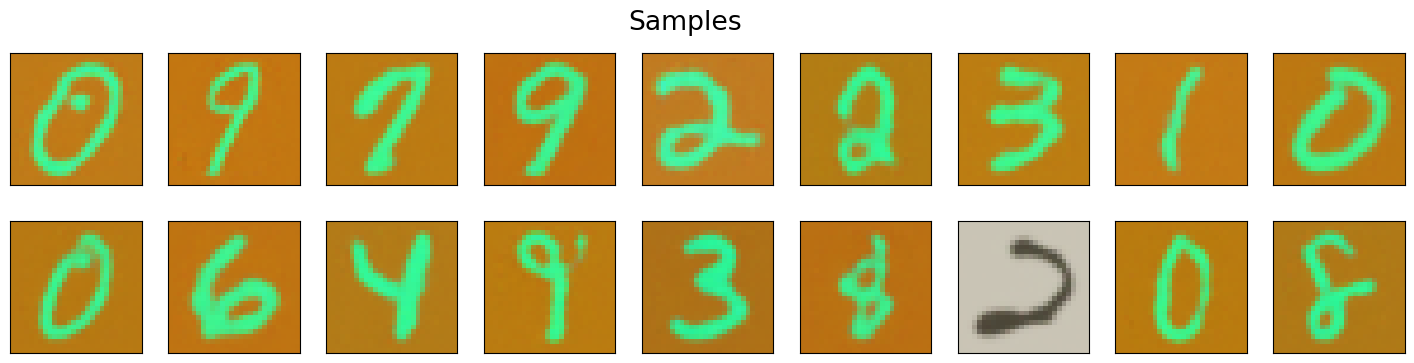

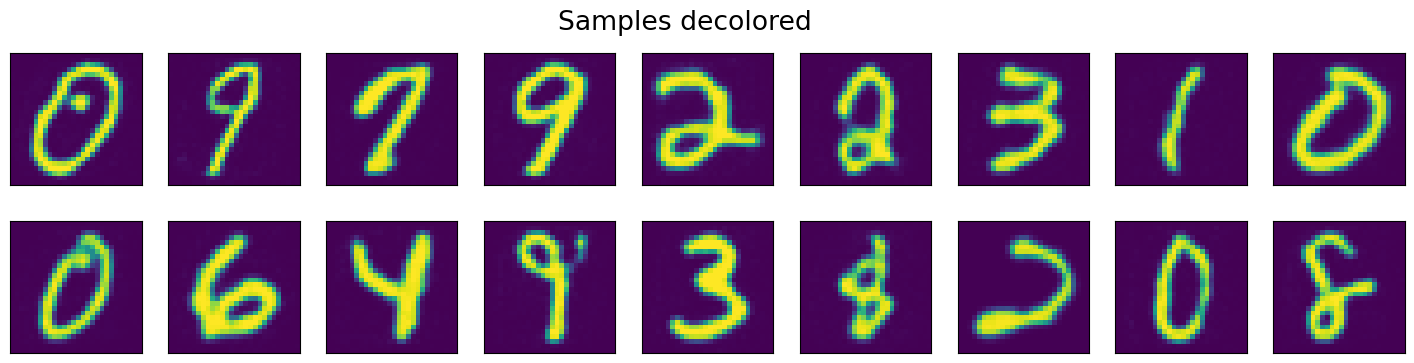

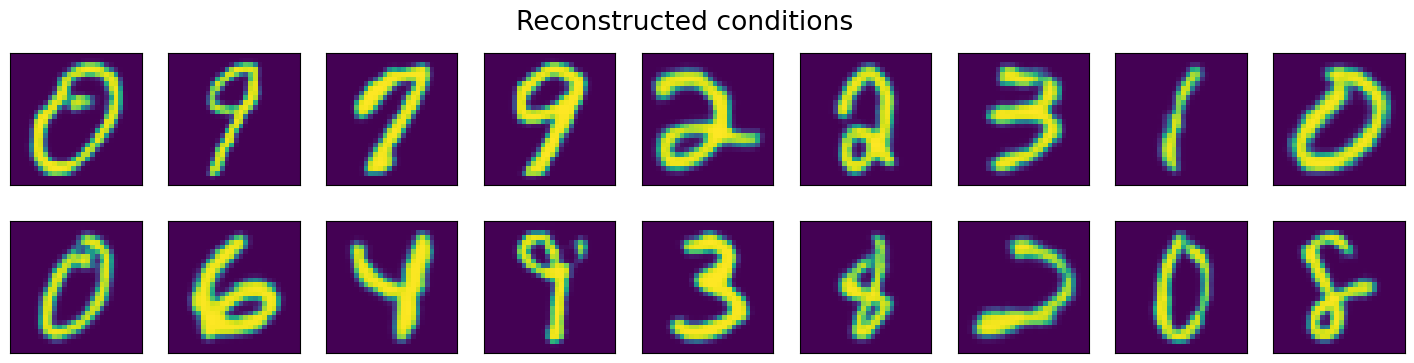

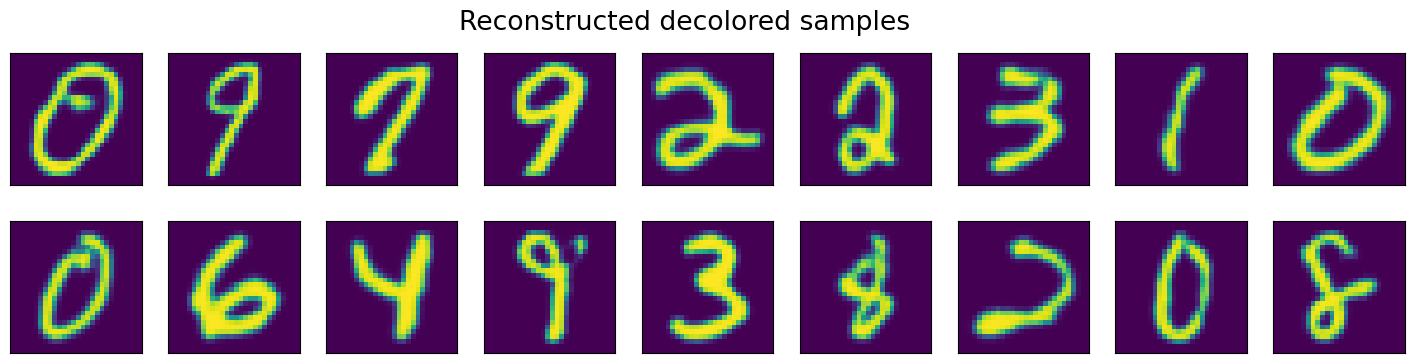

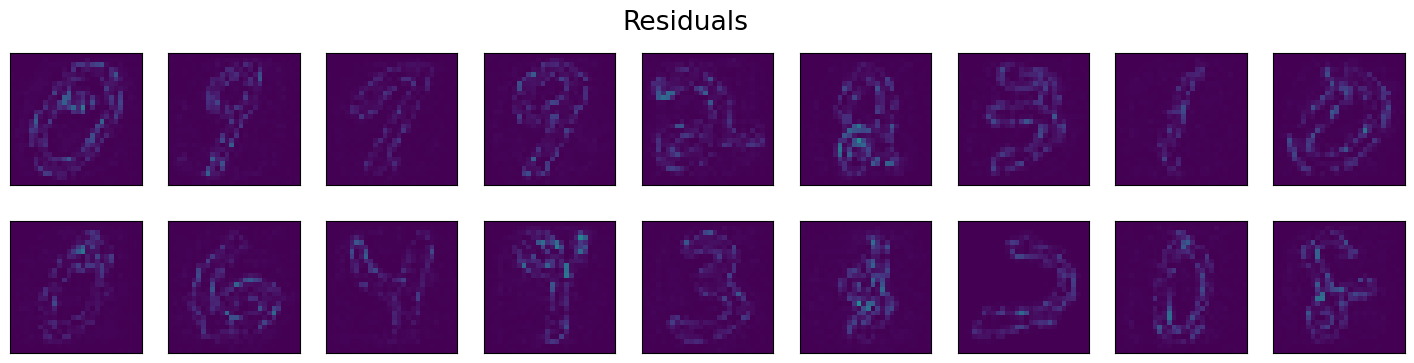

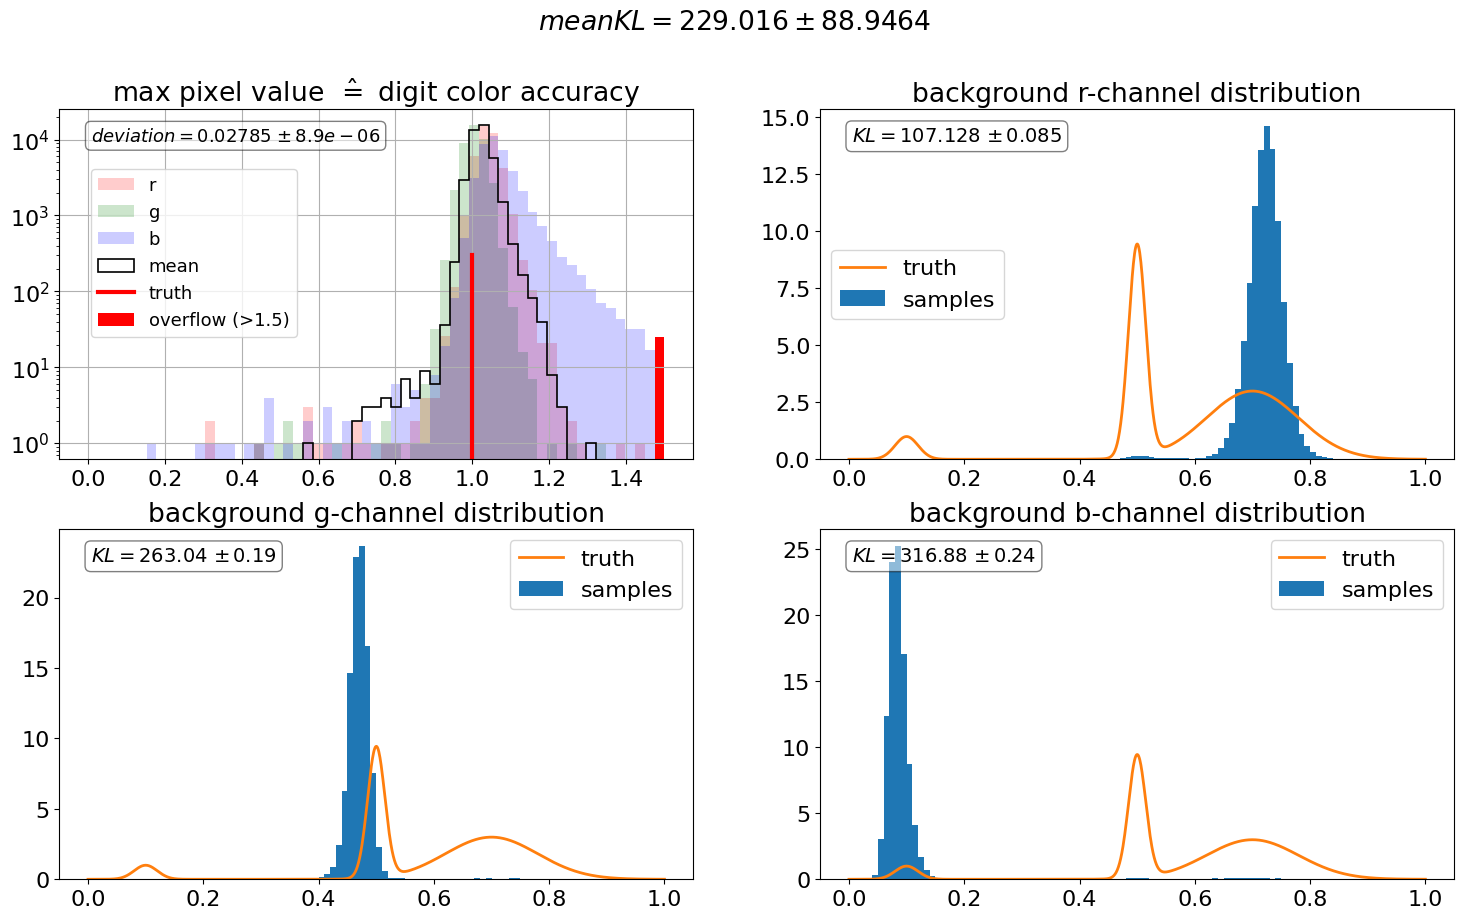

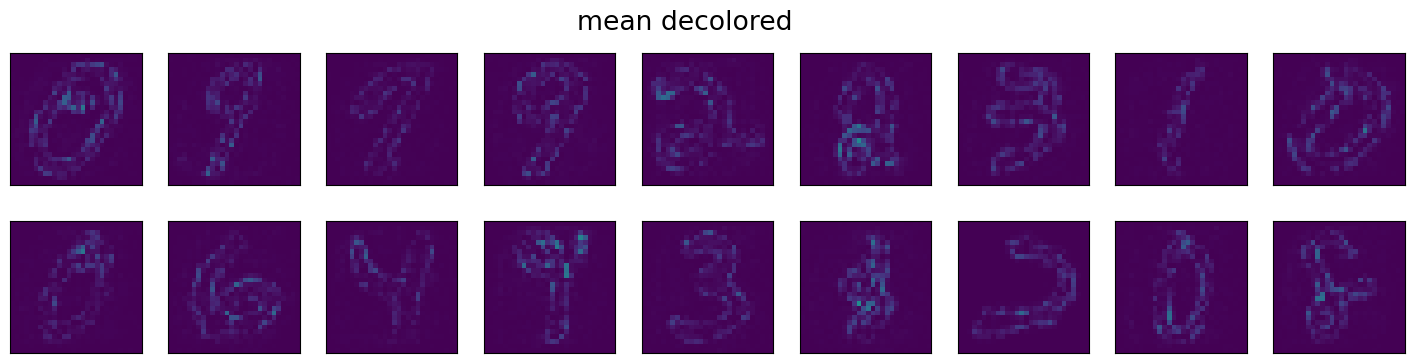

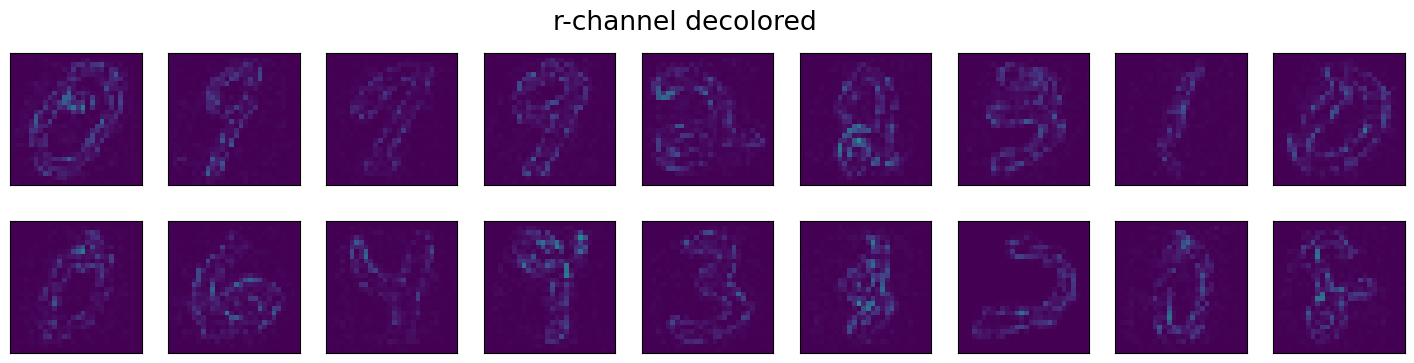

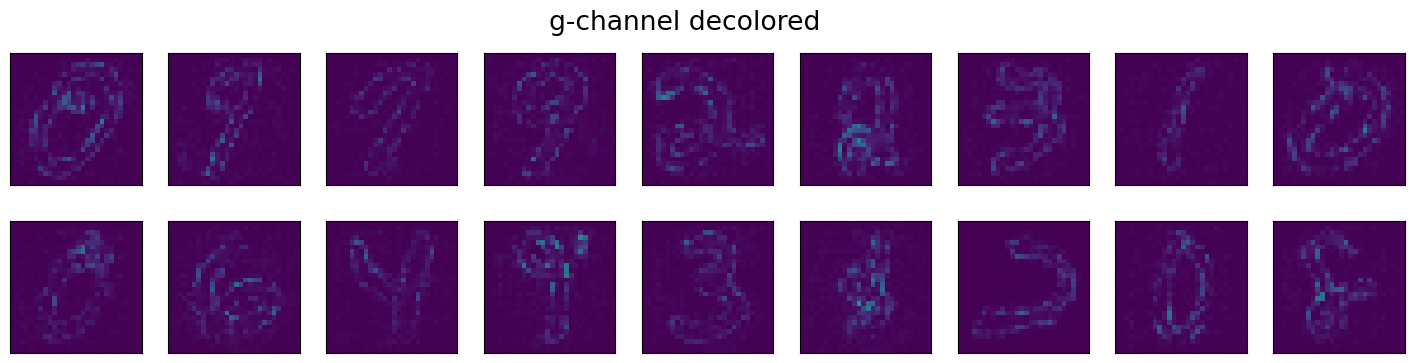

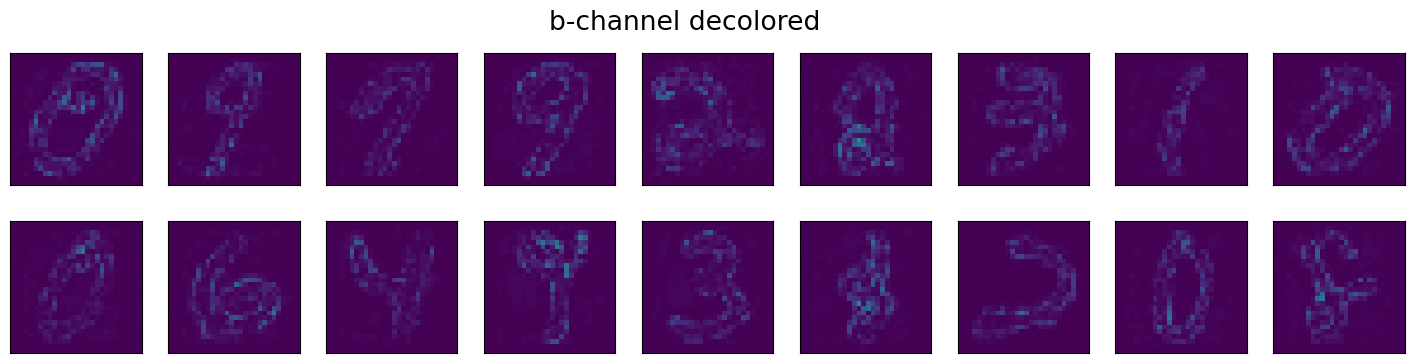

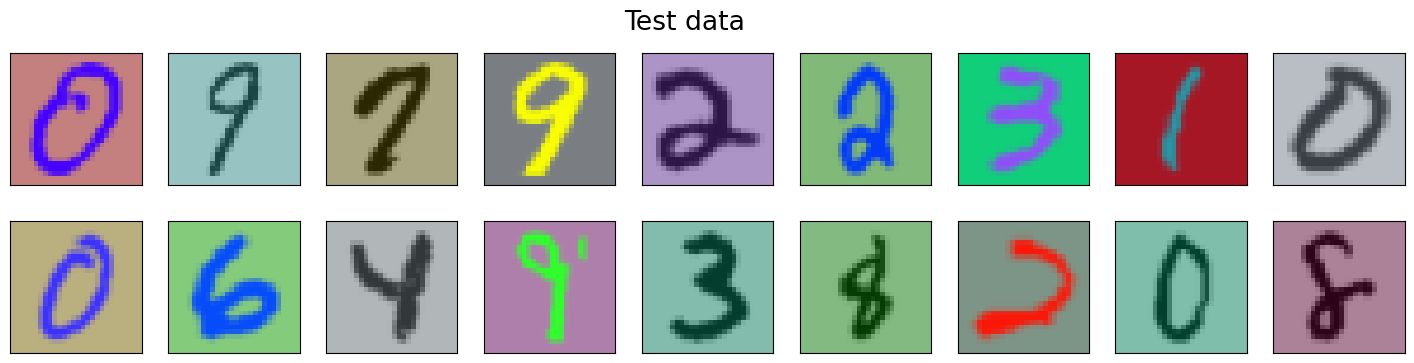

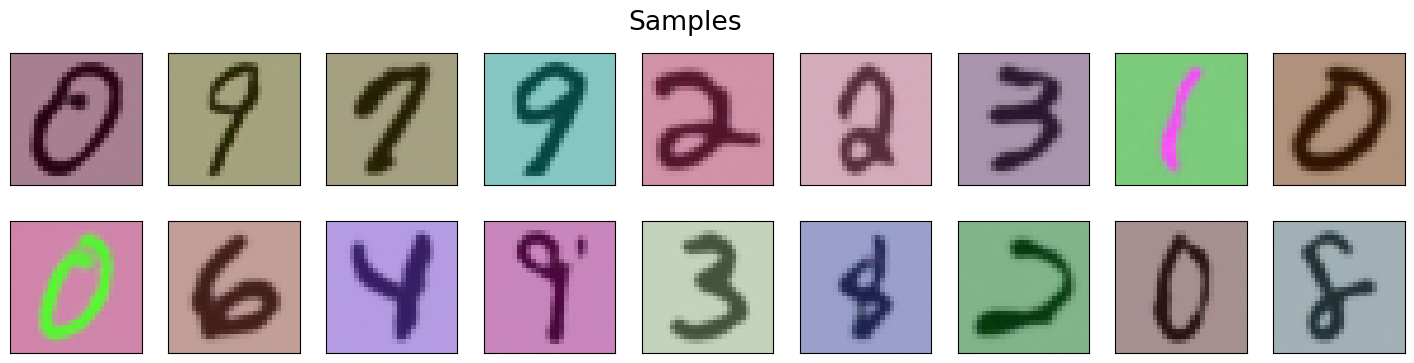

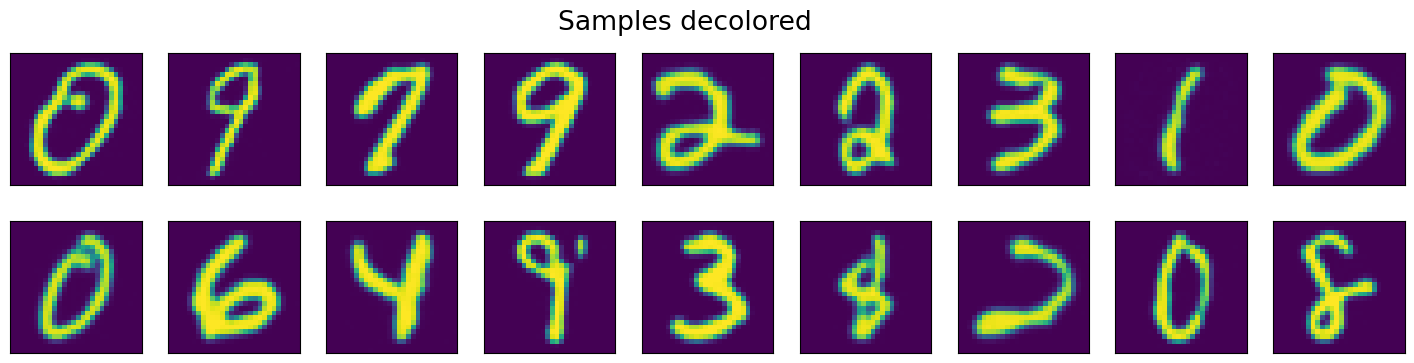

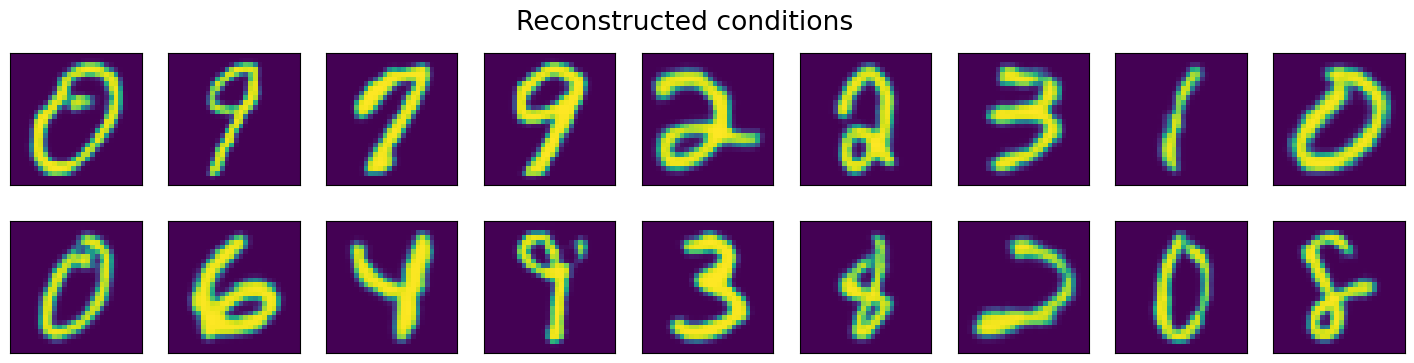

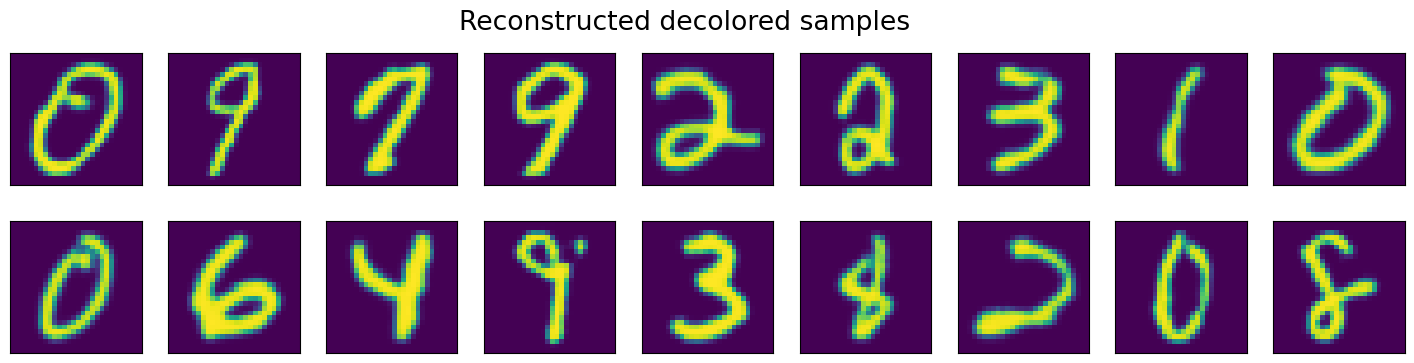

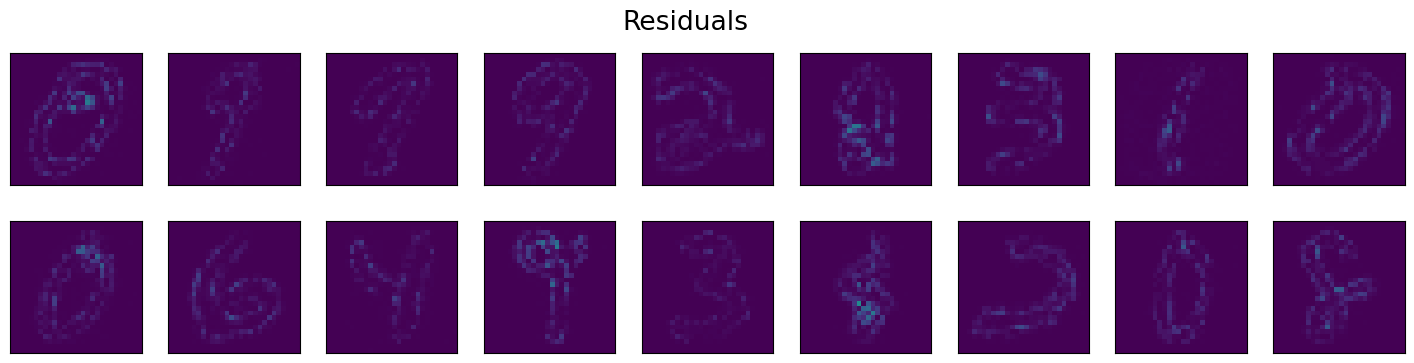

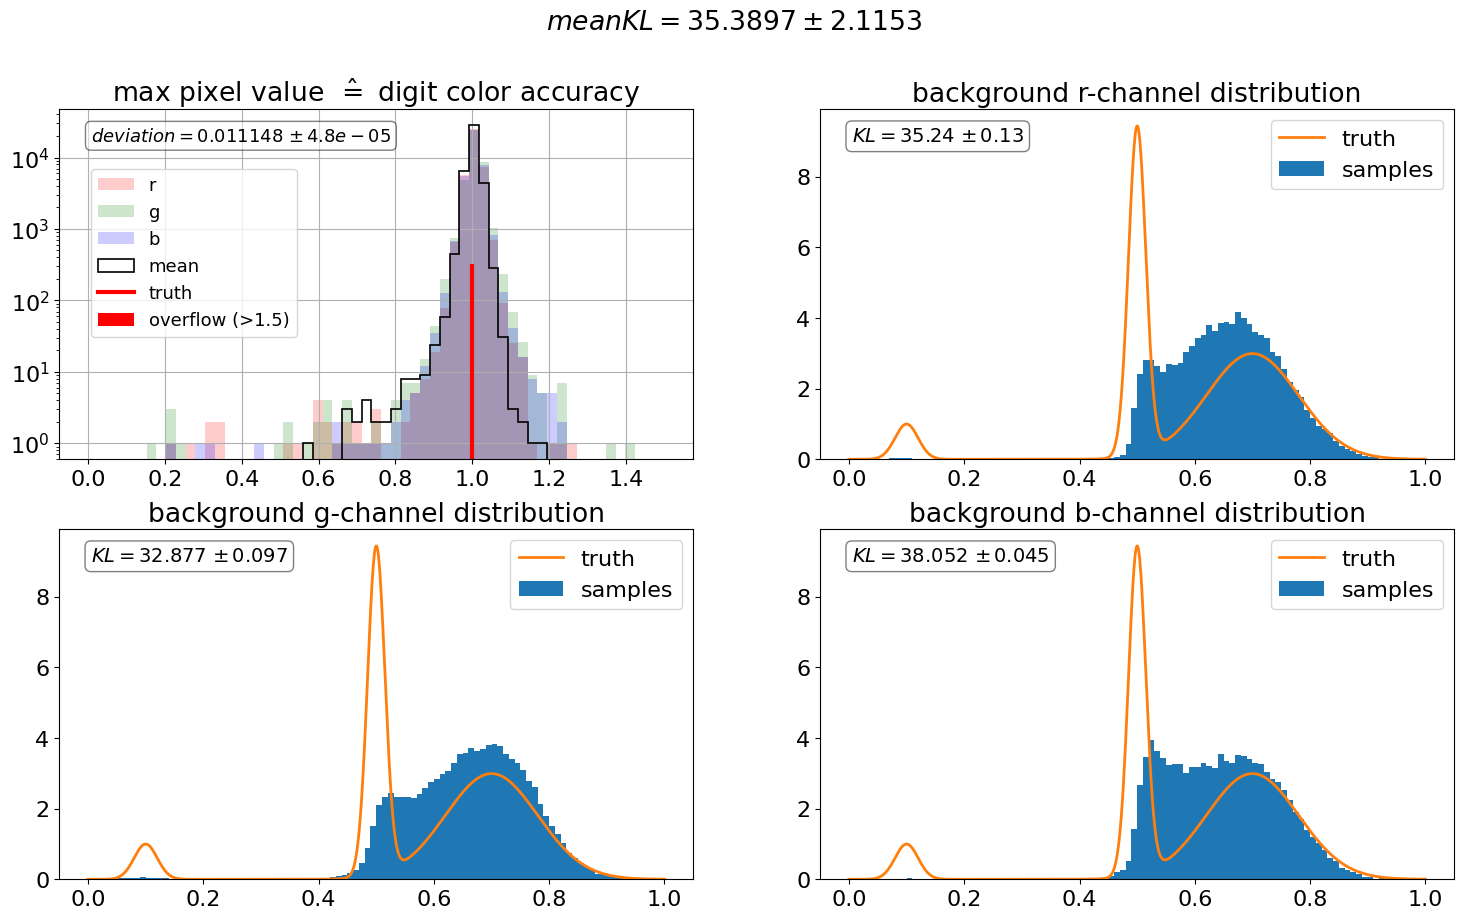

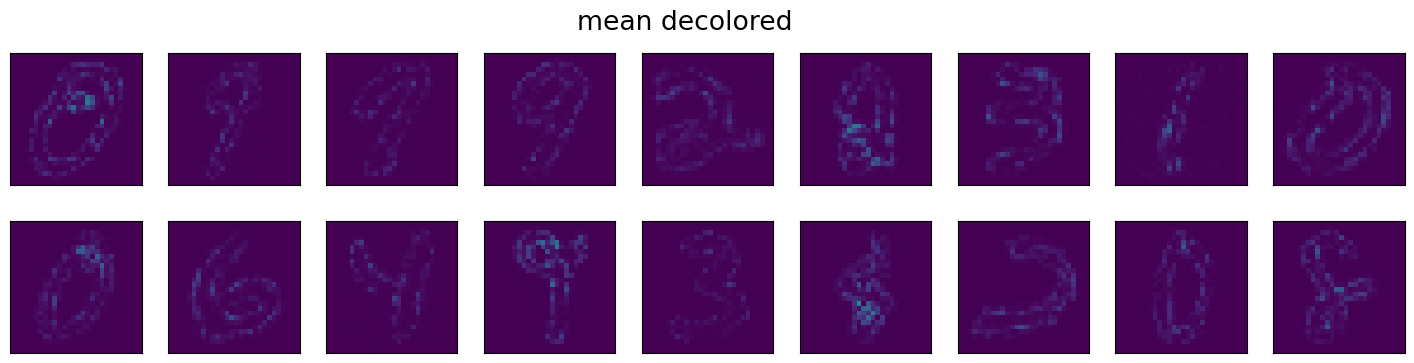

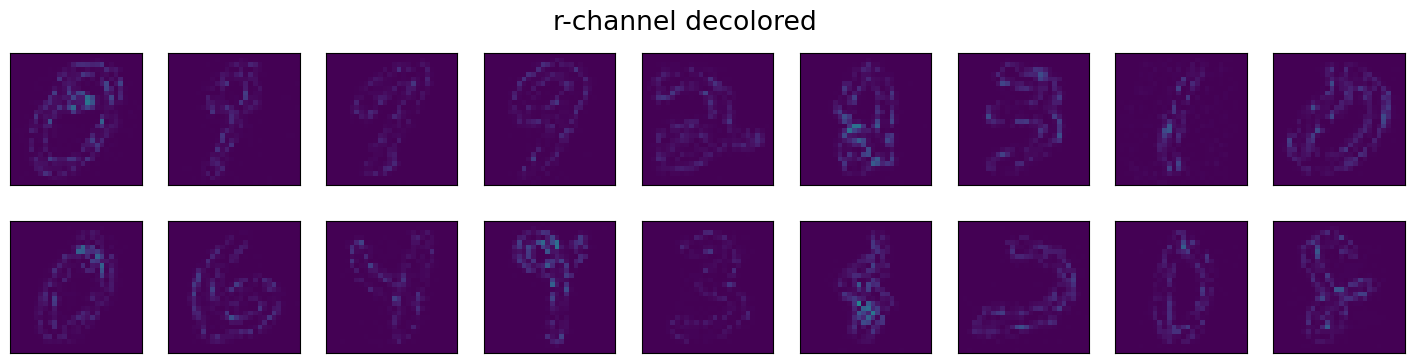

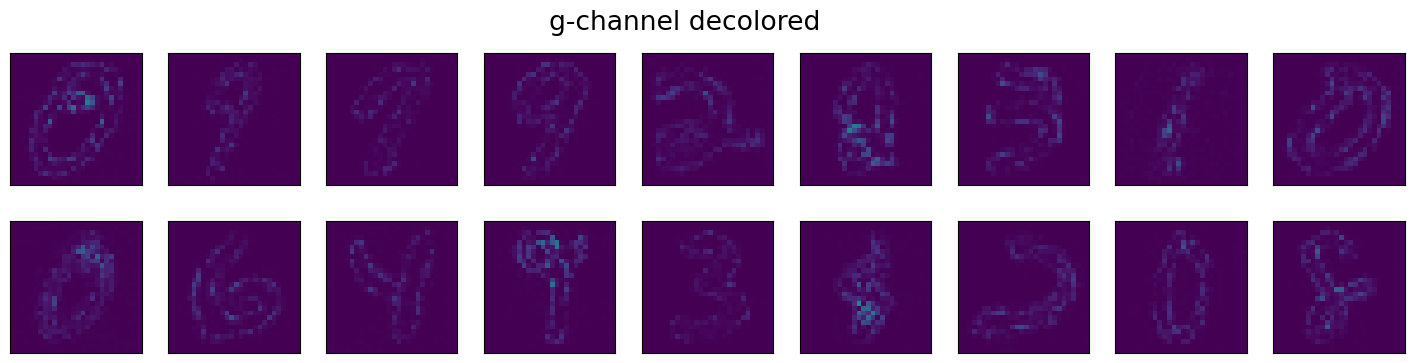

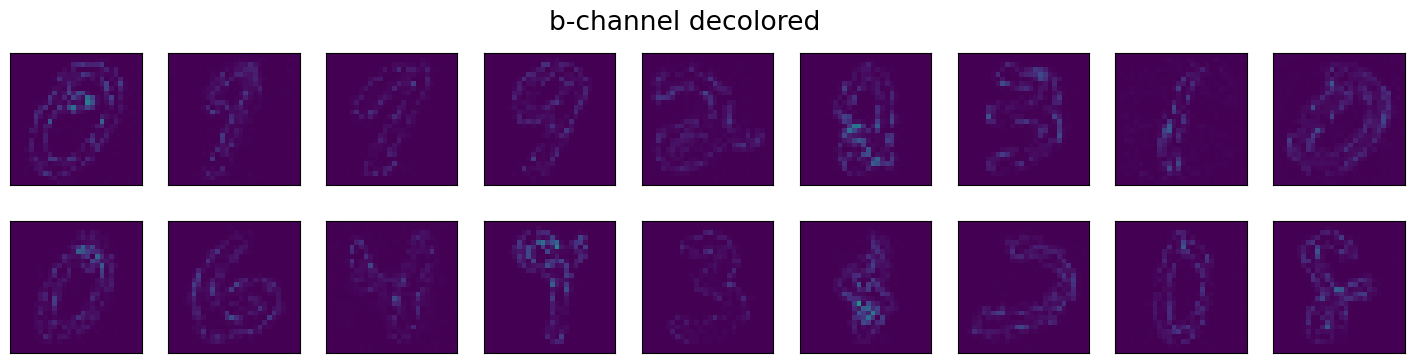

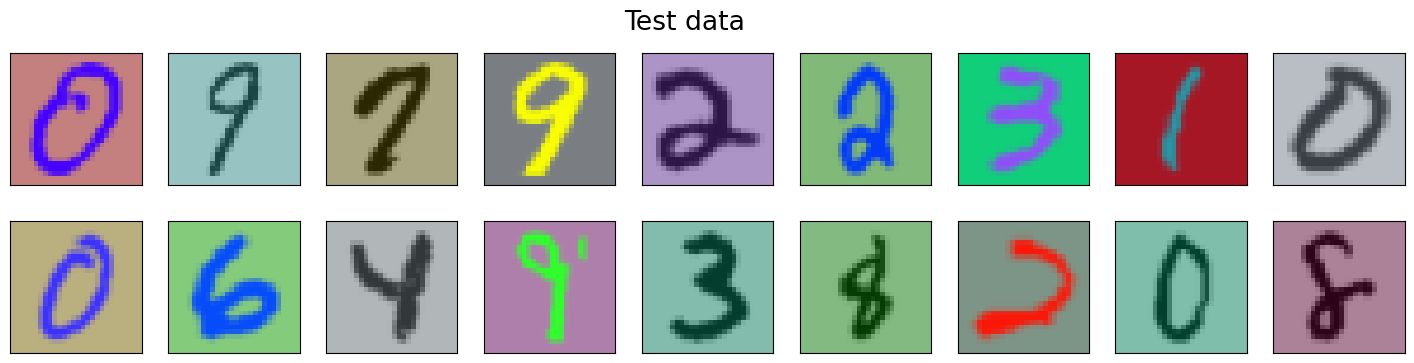

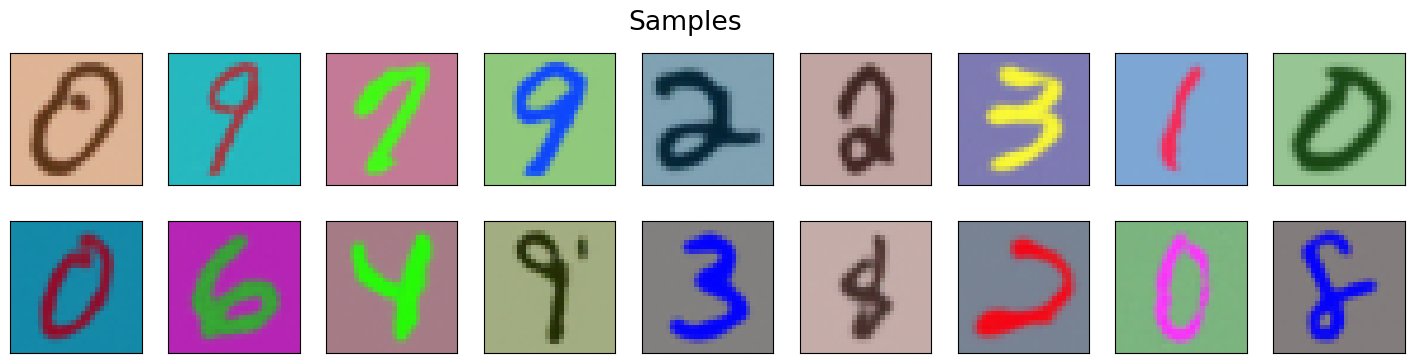

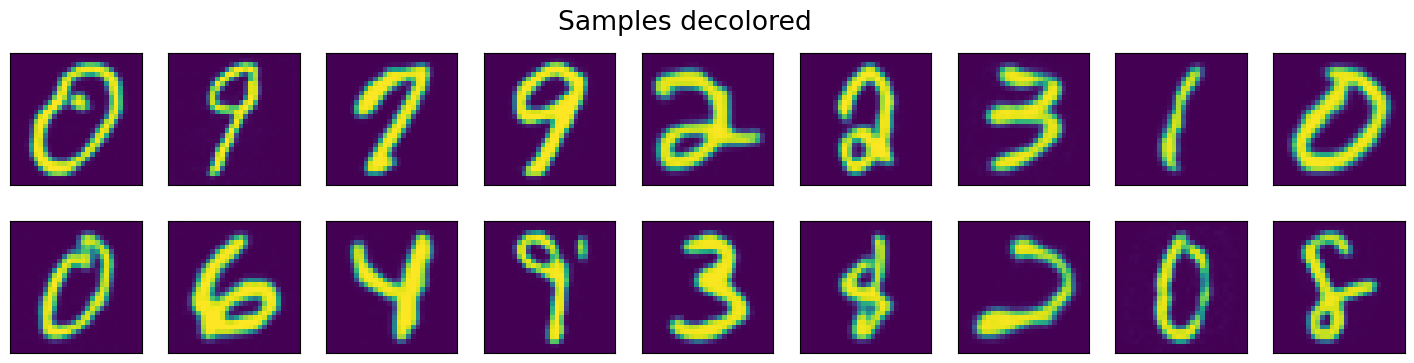

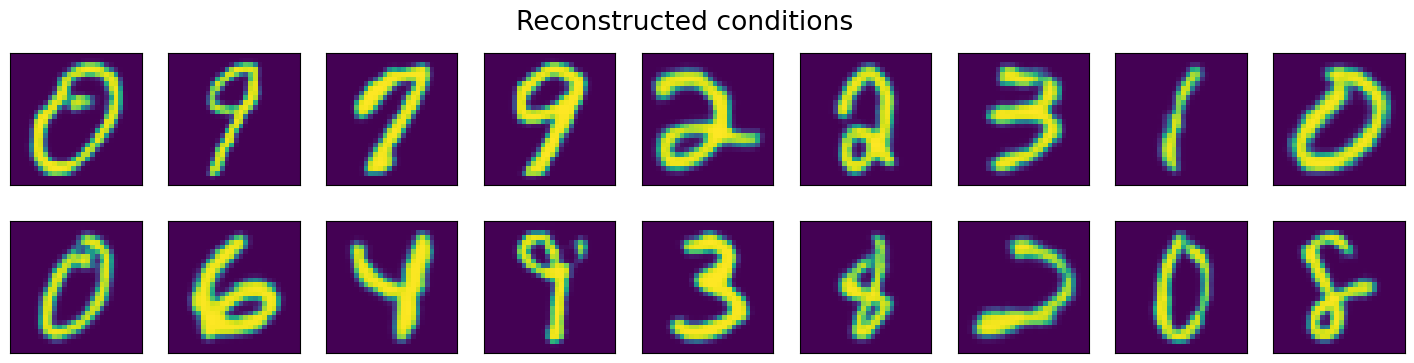

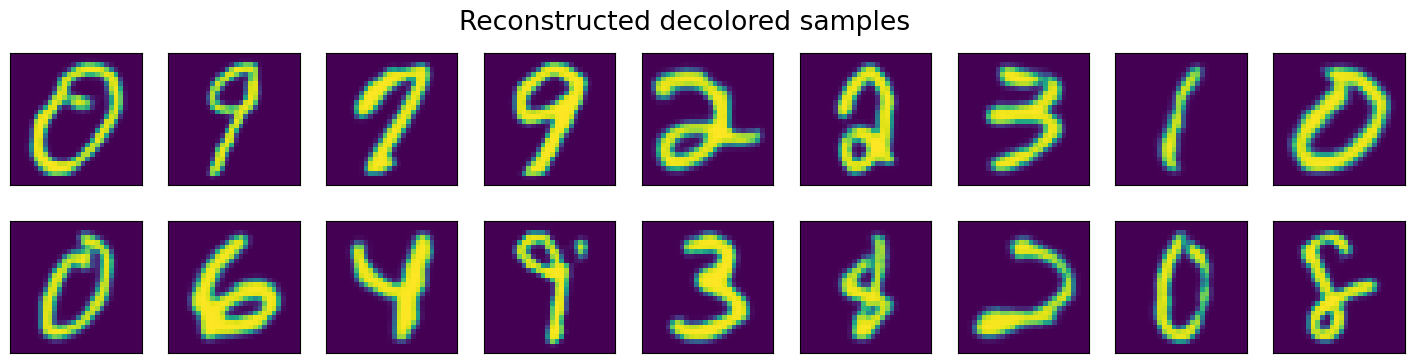

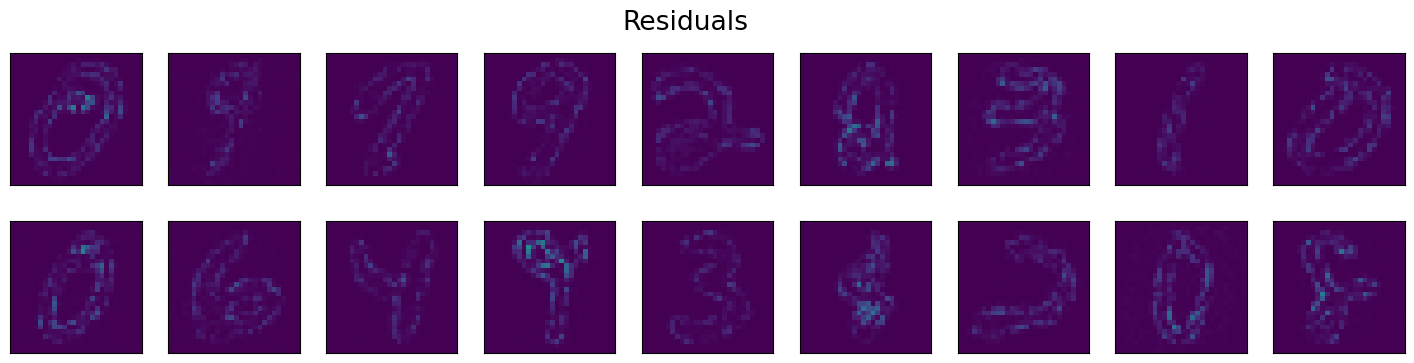

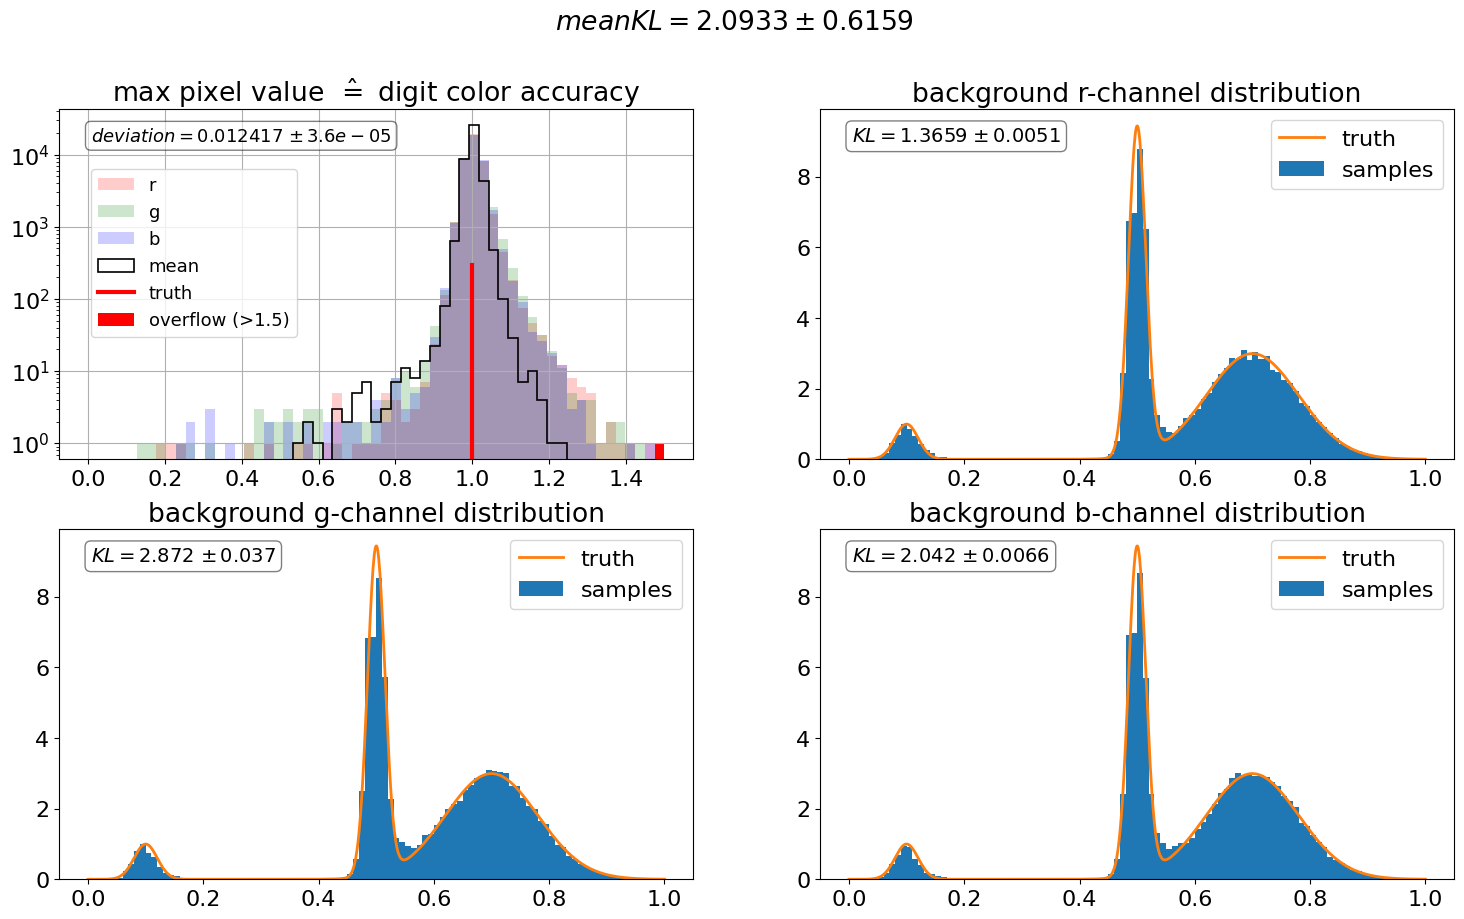

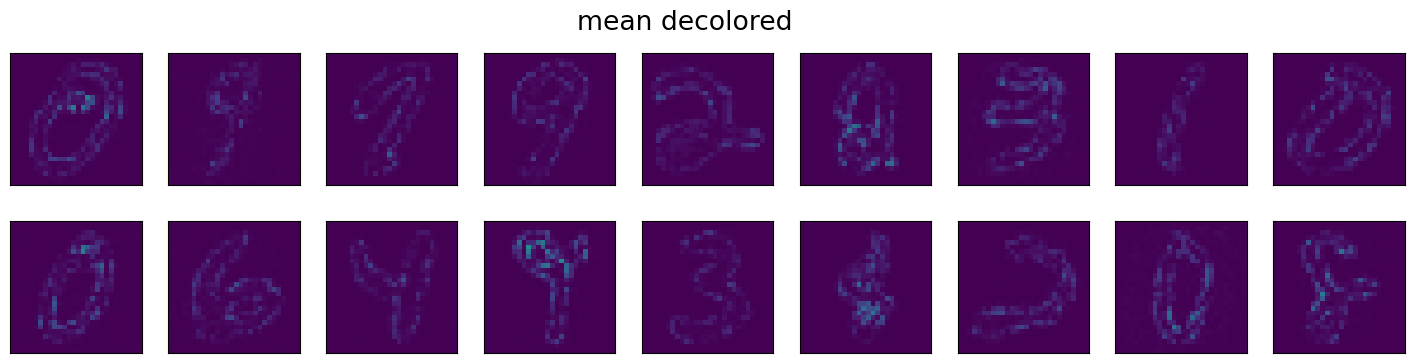

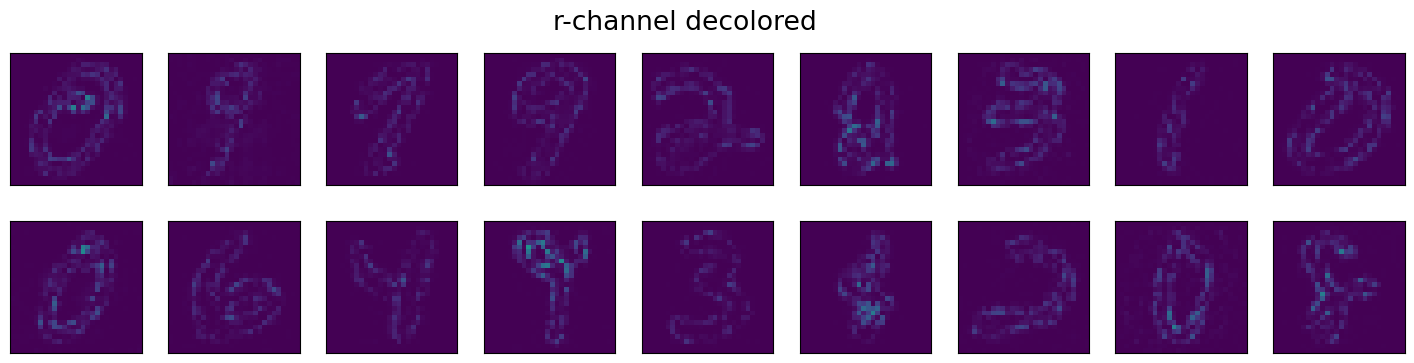

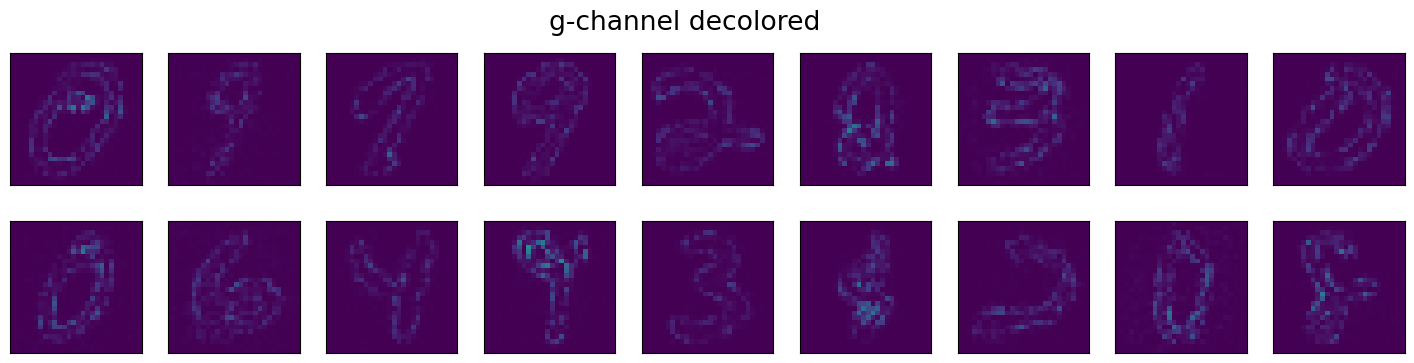

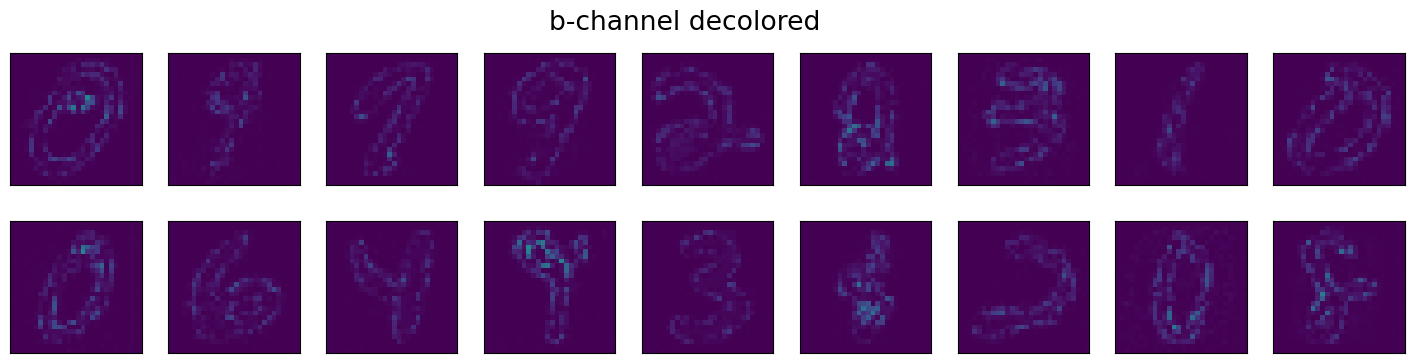

In [20]:
torch.set_grad_enabled(False)
for name in names:
    print(name)
    try:
        checkpoint = lightning_trainable.utils.find_checkpoint(root=f"lightning_logs/{name}", version=0, epoch="best")
    except:
        checkpoint = lightning_trainable.utils.find_checkpoint(root=f"lightning_logs/{name}", version=0, epoch="last")
    model = fff.fiber_model.FiberModel.load_from_checkpoint(checkpoint).eval()
    subject_model = model.subject_model.model
    fiber_loss, samples_list, test_samples_list, rec_list = evaluate_model(model, 2, save=False, save_name=name, batch_size=16384)
    fiber_losses_all.append(fiber_loss)
    mean_kl_std, kl_means, kl_stds = plot_evaluation(samples_list, test_samples_list, rec_list, save=False, save_name=name)
    mean_kl_std_all.append(mean_kl_std)
    print(len(mean_kl_std_all))

In [24]:
with h5py.File(f'notebooks/Fiber_Learning/saved_KL_std.h5', 'w') as f:
    f.create_dataset('mean_kl', data=mean_kl_std_all)
    f.create_dataset('names', data=names)

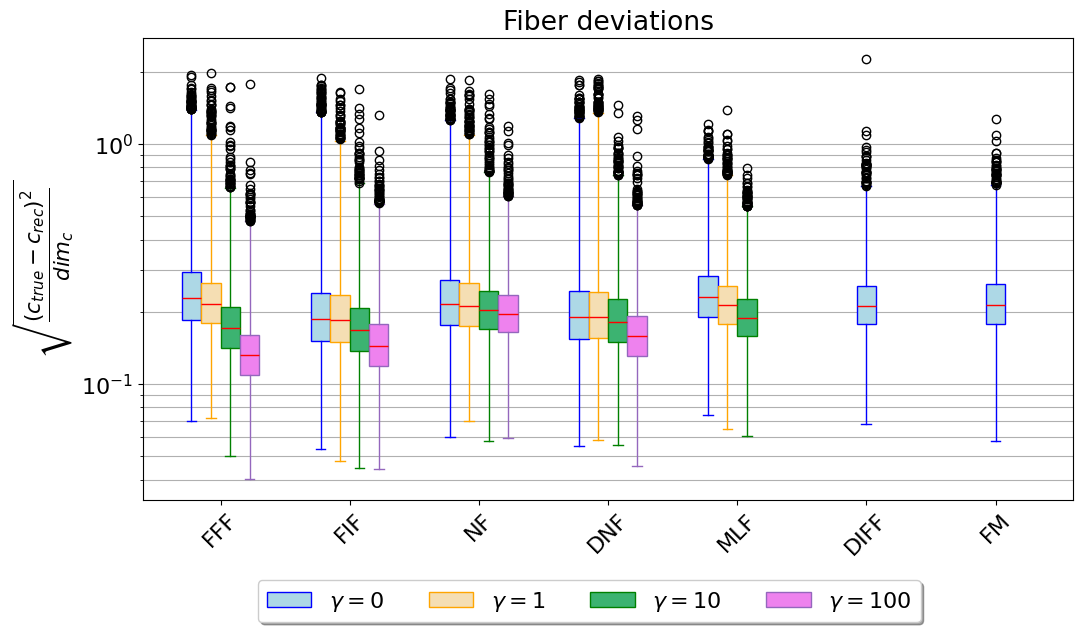

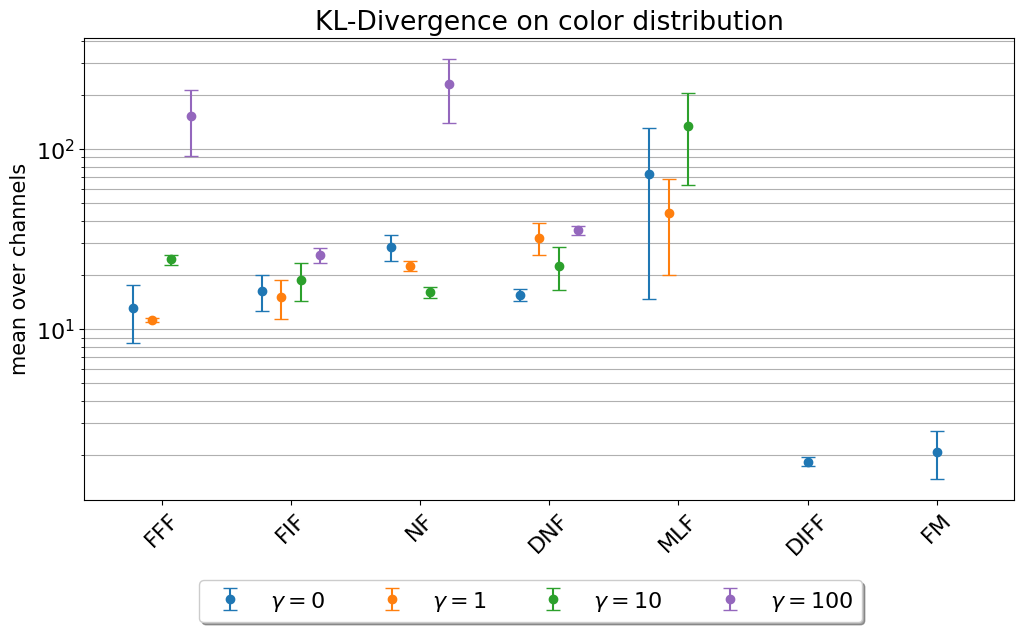

In [29]:
plt.figure(figsize=(12, 6))
x_names = ["FFF", "FIF", "NF", "DNF", "MLF", "DIFF", "FM"]
bpvs = []
for name in names:
    with h5py.File(f'plots/{plot_dir}/{name}/fiber_loss.h5', 'r') as f:
        bpvs.append(np.array(f['fiber_loss']))
x = [0,1,2,3,4,5,6]
x0 = [0,1,2,3,4,5.225,6.225]
x1 = [0,1,2,3,4]
x2 = [0,1,2,3,4]
x3 = [0,1,2,3]
inds_0 = [4,0,8,11,14,17,20]
inds_1 = [5,1,9,12,15]
inds_2 = [6,2,10,13,16]
inds_3 = [7,3,18,19]
pos_0 = np.array(x0) - 0.225
pos_1 = np.array(x1) - 0.075
pos_2 = np.array(x2) + 0.075
pos_3 = np.array(x3) + 0.225
bpvs0 = [bpvs[i][0] for i in inds_0]
bpvs1 = [bpvs[i][0] for i in inds_1]
bpvs2 = [bpvs[i][0] for i in inds_2]
bpvs3 = [bpvs[i][0] for i in inds_3]
plt.boxplot(bpvs0, vert=True, patch_artist=True, whis=(0, 99.9), positions=pos_0,widths=0.15,label=r"$\gamma=0$",
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            medianprops=dict(color='red'))
plt.boxplot(bpvs1, vert=True, patch_artist=True, whis=(0, 99.9), positions=pos_1,widths=0.15,label=r"$\gamma=1$",
            boxprops=dict(facecolor='wheat', color='orange'),
            whiskerprops=dict(color='orange'),
            capprops=dict(color='orange'),
            medianprops=dict(color='red'))
plt.boxplot(bpvs2, vert=True, patch_artist=True, whis=(0, 99.9), positions=pos_2,widths=0.15,label=r"$\gamma=10$",
            boxprops=dict(facecolor='mediumseagreen', color='green'),
            whiskerprops=dict(color='green'),
            capprops=dict(color='green'),
            medianprops=dict(color='red'))
plt.boxplot(bpvs3, vert=True, patch_artist=True, whis=(0, 99.9), positions=pos_3,widths=0.15,label=r"$\gamma=100$",
            boxprops=dict(facecolor='violet', color="tab:purple"),
            whiskerprops=dict(color="tab:purple"),
            capprops=dict(color="tab:purple"),
            medianprops=dict(color='red'))
plt.xticks(x, x_names[:],rotation=45)
plt.grid(axis='y', which="both", ls="-")
plt.ylabel(r"$\sqrt{\frac{(c_{true}-c_{rec})^2}{dim_c}}$", fontsize=22)
plt.title("Fiber deviations")
plt.yscale('log')
plt.xlim(-0.6,6.6)
#plt.ylim(0.01, 0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.15),
          ncol=4, fancybox=True, shadow=True)
path = f"plots/{plot_dir}/fiber_dist.png"
plt.savefig(path, bbox_inches='tight')
plt.show()

y_0 = [mean_kl_std_all[i][0] for i in inds_0]
y_1 = [mean_kl_std_all[i][0] for i in inds_1]
y_2 = [mean_kl_std_all[i][0] for i in inds_2]
y_3 = [mean_kl_std_all[i][0] for i in inds_3]
y_error_0 = [mean_kl_std_all[i][1] for i in inds_0]
y_error_1 = [mean_kl_std_all[i][1] for i in inds_1]
y_error_2 = [mean_kl_std_all[i][1] for i in inds_2]
y_error_3 = [mean_kl_std_all[i][1] for i in inds_3]
plt.figure(figsize=(12, 6))
plt.errorbar(pos_0, y_0, y_error_0, fmt="o", capsize=5,label=r"$\gamma=0$")
plt.errorbar(pos_1, y_1, y_error_1, fmt="o", capsize=5,label=r"$\gamma=1$")
plt.errorbar(pos_2, y_2, y_error_2, fmt="o", capsize=5,label=r"$\gamma=10$")
plt.errorbar(pos_3, y_3, y_error_3, fmt="o", capsize=5,label=r"$\gamma=100$", c="tab:purple")
plt.xticks(x, x_names[:],rotation=45)
plt.grid(axis='y', which="both", ls="-")
plt.ylabel("mean over channels", fontsize=15)
plt.title("KL-Divergence on color distribution")
plt.yscale("log")
plt.xlim(-0.6,6.6)
#plt.ylim(0.01, 0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.15),
          ncol=4, fancybox=True, shadow=True)
path = f"plots/{plot_dir}/KLDs.png"
plt.savefig(path, bbox_inches='tight')
plt.show()

In [ ]:
from functools import partial
def relaxed_c_density(x, c, subject_model, epsilon=0.1):
    c0 = subject_model.encode(x.to("cuda"), torch.empty(x.shape[0],device="cuda")).cpu()
    sigma_c = epsilon
    mu_c = c0
    Norm_c = torch.sqrt((2*torch.pi*sigma_c)**c.shape[1])
    density = 1/Norm_c * torch.exp(-((torch.sum((c-mu_c)**2, dim=1)/(2*sigma_c**2))).double())
    return density

def get_c_density_fnc(c, subject_model, epsilon=100):
    return partial(relaxed_c_density, c=c, subject_model=subject_model, epsilon=epsilon)

In [146]:
test_set_c = Xt[:10]
test_set_x = torch.utils.data.TensorDataset(Xt[10:])

In [147]:
def evaluate_model_FQ(model2plt):
    batch_size = 256
    #dataloader = torch.utils.data.DataLoader(model2plt.test_data, batch_size=batch_size, shuffle=False)
    dataloader = torch.utils.data.DataLoader(test_set_x, batch_size=batch_size, shuffle=False)
    plot_forward_fiber_quality(model2plt, model2plt.subject_model, dataloader, test_set_c, clip_energy=10000, batch_size=batch_size)

In [150]:
from math import prod
from torch.autograd.functional import jacobian
from torch.func import jacrev
from fff.utils.func import *

@torch.no_grad()
def plot_forward_fiber_quality(fiber_model, subject_model, test_loader, X_test_c, epsilon_range=[0.02, 0.5], num_epsilons=5, batch_size=512, model_name="Fiber model", color="C0", clip_energy=None, nf=True):
    fiber_model.to("cuda")
    device = fiber_model.device
    c_test_batch = fiber_model.subject_model.encode(X_test_c.to(device), torch.empty(X_test_c.shape[0],device=device)).cpu()
    
    nlls, x_data = [], []
    print("compute NLL")
    for i, c_test in enumerate(c_test_batch):
        print(i)
        for x in test_loader:
            x = x[0].to(device)
            c_batch = c_test.repeat(x.shape[0],1).to(x.device)

            z, Jacs = compute_jacobian(x.reshape(-1, 3*28*28), fiber_model.encode, c_batch, chunk_size=None)
            Jacs = Jacs.squeeze()
            log_jacs_complete = torch.bmm(Jacs, Jacs.permute((0,-1,-2))).logdet()/2
            i_invalid = torch.logical_or(torch.isinf(log_jacs_complete), torch.isnan(log_jacs_complete)).cpu()
            nll = torch.mean(z**2, dim=1)/2 - log_jacs_complete/z.shape[1]
            nlls.append(nll[~i_invalid].cpu())
            x_data.append(x.cpu())
        if i==5:
            break

    print("computing FQ")
    x_data = torch.cat(x_data, dim=0)
    #c_data = torch.cat(c_data, dim=0)
    nlls = torch.cat(nlls, dim=0)
    print(nlls.shape)
    sample_dataset = torch.utils.data.TensorDataset(x_data, nlls)
    sample_loader = torch.utils.data.DataLoader(sample_dataset, batch_size=batch_size, shuffle=False)

    fqs = []
    for i, epsilon in enumerate(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons)):
        fqs_epsilon = []
        for x, nll in sample_loader:
            c_batch = c_test.repeat(x.shape[0],1).to(x.device)
            #Jac_sm = batch[2].reshape(-1,48,3*28*28)
            #logj_sm = torch.bmm(Jac_sm, Jac_sm.permute((0,-1,-2))).logdet()/2
            c_density_fnc = get_c_density_fnc(c_batch, subject_model, epsilon)
            fqs_epsilon.append(c_density_fnc(x).cpu() * nll)
        fqs.append(torch.cat(fqs_epsilon, dim=0))
        print(fqs[-1][torch.isnan(fqs[-1])].shape)

    fqs = torch.stack(fqs, dim=0).cpu().detach().numpy()
    if clip_energy is not None:
        print(f"{(fqs > clip_energy).sum(axis=1)*100/prod(fqs.shape[1:])} % are clipped")
        fqs[fqs > clip_energy] = clip_energy

    print(-fqs.mean(axis=1))
    plt.plot(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons), - fqs.mean(axis=1), color=color, label=model_name)
    bootstrap_samples = []
    for i in range(1000):
        bootstrap_idx = np.random.choice(fqs.shape[1], fqs.shape[1])
        bootstrap_samples.append(np.mean(fqs[:, bootstrap_idx], axis=1))
    bootstrap_samples = np.stack(bootstrap_samples, axis=1)
    bootstrap_mean = np.mean(bootstrap_samples, axis=1)
    bootstrap_std = np.std(bootstrap_samples, axis=1)
    plt.fill_between(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons), - bootstrap_mean - 2 * bootstrap_std, - bootstrap_mean + 2 * bootstrap_std, color=color, alpha=0.3)

    plt.scatter(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons), - fqs.mean(axis=1), color=color, s=5)
    plt.show()

compute NLL
0
1
2
3
4
5
computing FQ
torch.Size([239940])
torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([0])
[0. 0. 0. 0. 0.] % are clipped
[-0.00000000e+000 -0.00000000e+000 -0.00000000e+000 -2.86582658e-136
 -4.64268639e-043]


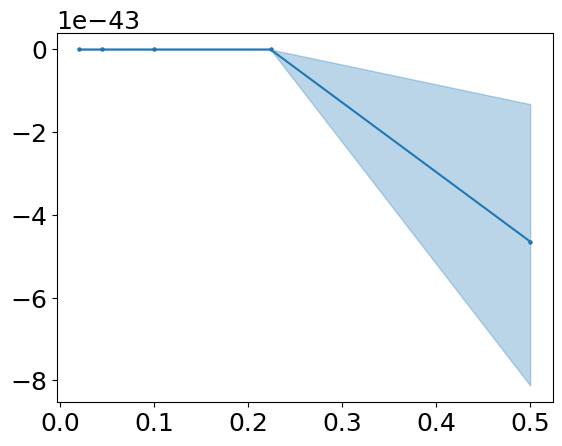

In [151]:
evaluate_model_FQ(model)

In [70]:
from math import prod
from torch.autograd.functional import jacobian
from torch.func import jacrev
from fff.utils.func import *

def log_Z(beta, dim=2):
    return np.log(beta)*dim + dim / 2 * np.log(2 * np.pi)

@torch.no_grad()
def plot_fiber_quality(fiber_model, subject_model, test_loader, epsilon_range=[0.0005, 0.05], num_epsilons=5, batch_size=512, model_name="Fiber model", color="C0", clip_energy=None, nf=True):
    fiber_model.to("cuda")
    device = fiber_model.device
    #logj_sms, log_jacs, x_data, c_data = [], [], [], []
    nlls = []
    valid_shapes = []

    print("computing FQ")
    nlls = []
    for i, epsilon in enumerate(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons)):
        nlls_epsilon = []
        print(epsilon)
        i=0
        for batch in test_loader:
            test_conditioned = fiber_model.apply_conditions(batch[:2])
            #test_c = test_conditioned.condition.to(device)
            test_samples = test_conditioned.x0.to(device).reshape(-1,3*28*28)
            Jac_sm = batch[2].reshape(-1,48,3*28*28)
            logj_sm = torch.bmm(Jac_sm, Jac_sm.permute((0,-1,-2))).logdet()/2
            c_distribution = get_c_distribution(subject_model, logj_sm, epsilon)
            c_sampled = c_distribution(test_samples)
            
            z, Jacs = compute_jacobian(test_samples, fiber_model.encode, c_sampled, chunk_size=None)
            Jacs = Jacs.squeeze()
            log_jacs_complete = torch.bmm(Jacs, Jacs.permute((0,-1,-2))).logdet()/2
            i_invalid = torch.logical_or(torch.isinf(log_jacs_complete), torch.isnan(log_jacs_complete)).cpu()
            nll = torch.mean(z**2, dim=1)/2 - log_jacs_complete/z.shape[1]
            #logj_sms.append(logj_sm[~i_invalid].cpu())
            nlls_epsilon.append(nll[~i_invalid].cpu())
            #x_data.append(test_samples[~i_invalid].cpu())
            #c_data.append(test_c[~i_invalid].cpu())
            i+=1
            if i%100==0:
                print(i)
            if i==2000:
                break
        nlls_epsilon = torch.cat(nlls_epsilon, dim=0)
        valid_shapes.append(nlls_epsilon.shape[0])
        nlls.append(nlls_epsilon.numpy())
    print(valid_shapes)

    bootstrap_mean, bootstrap_std = [], []
    for nll_epsilon in nlls:
        print(nll_epsilon[:20])
        if clip_energy is not None:
            print(f"{(nll_epsilon > clip_energy).sum(axis=0)*100/prod(nll_epsilon.shape[:])} % are clipped")
            nll_epsilon[nll_epsilon > clip_energy] = clip_energy
        bootstrap_samples = []
        for i in range(1000):
            bootstrap_idx = np.random.choice(nll_epsilon.shape[0], nll_epsilon.shape[0])
            bootstrap_samples.append(np.mean(nll_epsilon[bootstrap_idx]))
        bootstrap_samples = np.array(bootstrap_samples)
        bootstrap_mean.append(np.mean(bootstrap_samples))
        bootstrap_std.append(np.std(bootstrap_samples))
    bootstrap_mean, bootstrap_std = np.array(bootstrap_mean), np.array(bootstrap_std)
        
    nlls_mean = np.array([nll_epsilon.mean() for nll_epsilon in nlls])
    print(-nlls_mean)
    plt.plot(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons), - nlls_mean, color=color, label=model_name)
    
    plt.fill_between(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons), - bootstrap_mean - 2 * bootstrap_std, - bootstrap_mean + 2 * bootstrap_std, color=color, alpha=0.3)

    plt.scatter(torch.logspace(np.log10(epsilon_range[0]), np.log10(epsilon_range[1]), num_epsilons), - nlls_mean, color=color, s=5)